# Twitter Sentiment Analysis
Sentiment analysis is a branch of Natural Language Processing (NLP) which allows us to determine whether a string of text is positive or negative. Sentiment analysis of social media data is important from a business standpoint as it allows organizations to analyze trends in public opinion. This information could motivate changes to business strategies to address areas of low customer satisfaction.

The goal of this assignment will be to develop a classifier capable of distinguishing positive sentiment tweets from those of negative sentiment. The classifier will be trained on generic twitter text, and then tested on a separate dataset consisting of only tweets regarding airline companies to demonstrate the generalizability of model to a business context. Naturally, the distribution words and labels differ between both datasets, so managing overfitting will be a challenge. By analyzing the data, we will determine what public opinion on Twitter tells us about US airlines in 2015. 

Two sets of Twitter data collected from the web will be used in this project:
- `generic_tweets.txt`: contains generic tweets that have had their sentiment already labeled (positive/negative). 200000 tweets were sampled from the [sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140)
- `US_airline_tweets.csv`: contains 11541 [tweets regarding different US airlines](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) from 2015



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from bs4 import BeautifulSoup 
import re
from PIL import Image
import multiprocessing
import os
import time
import pickle
import joblib
from tqdm.notebook import tqdm
from scipy.sparse.csr import csr_matrix

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_curve, classification_report,
                             roc_auc_score, f1_score, plot_confusion_matrix,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier
import xgboost as xgb

from gensim.models import KeyedVectors, Word2Vec 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, callbacks, optimizers

## Data Import & Cleaning 
First we will load the generic tweet data into a pandas dataframe so that we can manipulate and use the data.

Below are the column descriptions of `generic_tweets.txt`:
- **class** : the polarity/sentiment of the tweet (0=negative, 4=positive)
- **id** : unique tweet id number
- **date** : date of the tweet
- **query** : the query
- **user** : twitter account username of the tweet
- **text** : the text of the tweet

In [2]:
pwd = os.getcwd()
generic_filepath = os.path.join(pwd, 'datasets', 'generic_tweets.txt')
generic_df = pd.read_csv(generic_filepath, sep=',',header=0) # Import generic tweets as a pandas dataframe
generic_df.head() # Ensure everything has been imported in the correct format

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
generic_df.shape

(200000, 6)

The data types of each column of the dataframe are checked so we know what kind of data we are working with.

In [4]:
generic_df.dtypes

class     int64
id        int64
date     object
query    object
user     object
text     object
dtype: object

A separate dataframe is created to store information from a dataset containing US airline tweets. Like previously, the data type of each column of the dataframe is also checked.

The column descriptions of the `US_airline_tweets.csv` file are listed:
- **id** : unique tweet id number
- **sentiment** : tweet polarity (positive/negative)
- **negative_reason** : reason of the negative tweets (left blank for positive tweets)
- **user** : Twitter username that tweeted
- **retweet_count** : number of retweets
- **text** : the text of the tweet

In [5]:
airline_filepath = os.path.join(pwd, 'datasets', 'US_airline_tweets.csv')
airline_df = pd.read_csv(airline_filepath, header=0) #import US airline twitter data as a pandas dataframe
airline_df.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [6]:
airline_df.shape

(11541, 6)

In [7]:
airline_df.dtypes

id                 float64
sentiment           object
negative_reason     object
user                object
retweet_count        int64
text                object
dtype: object

Each tweet is not ready for analysis since there is too much noise using the tweets as is. To remove the noise from each tweet we need to preprocess it, or clean it prior to analysis.

A function `cleanTweet()` is defined that takes in twitter text as an input and performs the following operations prior to returning it:
- Removes HTML tags and attributes and converts HTML character codes to ASCII using the BeautifulSoup library
- Removes URLs
- Sets all characters in the text to lowercase
- Remove punctuation except for "@" since we need it to identify twitter tags later
- Removes stopwords

A disadvantage of this approach is that it does not incorporate text normalization techniques like stemming or lemmatization (with packages such as nltk). An advantage however is that it does not oversimplify or generalize the tweet data prior to analysis; the data is more representative of the raw data.

Since we will be using the Natural Language Tool Kit library, we will incorporate lemmatization to further normalize the words. Lemmatization works by reducing inflected words to their root or dictionary form (lemma).

In [8]:
### Text processing with nltk
def cleanTweet(tweet):
    soup = BeautifulSoup(tweet)
    cleanTweet = soup.get_text()  #remove html tags and attributes, and convert HTML character codes to ASCII
    cleanTweet = re.sub(r'http\S+', '', cleanTweet) #remove URLs
    cleanTweet = re.sub(r'[^\w\s@]', '', cleanTweet) #remove punctuation
    cleanTweet = cleanTweet.lower()  #convert text to lowercase
    
    # remove stopwords
    stoplist = set(stopwords.words('english'))
    cleanTweet_tokenized = word_tokenize(cleanTweet)
    tokenized_tweet_nostop = [word for word in cleanTweet_tokenized if word not in stoplist]
    
    # lemmatization
    tokenized_lemma = []
    lemmatizer = WordNetLemmatizer()
    for token in tokenized_tweet_nostop:
        token_lemma = lemmatizer.lemmatize(token)
        tokenized_lemma.append(token_lemma)     
    
    cleanTweet = " ".join(tokenized_lemma) #join tokens into a single string
    cleanTweet = re.sub(r'(?<=@)\s(?=\w+)', '', cleanTweet) #remove whitespace between @ username handles
    return cleanTweet

Once defined, the `cleanTweet()` function is applied to each tweet in the US airline dataframe and generic tweet dataframe respectively. The first few lines of the dataframes are then displayed to verify that the function worked as intended.

In [9]:
airline_df['cleantext'] = airline_df['text'].apply(cleanTweet)
airline_df.head()

,id,sentiment,negative_reason,user,retweet_count,text,cleantext
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,@virginamerica plus youve added commercial exp...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,@virginamerica really aggressive blast obnoxio...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,@virginamerica really big bad thing
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,@virginamerica seriously would pay 30 flight s...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",@virginamerica yes nearly every time fly vx âœ...


In [10]:
generic_df['cleantext'] = generic_df['text'].apply(cleanTweet)
generic_df.head()

,class,id,date,query,user,text,cleantext
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",@switchfoot awww thats bummer shoulda got davi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dived many time ball managed save 50...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",@nationwideclass behaving im mad cant see


## Exploratory Analysis
Before beginning to apply any machine learning algorithms on the datasets, exploratory analysis will be performed to familiarize ourselves with the data.

First, a procedure will be implemented which determines the airline of each tweet in the US airline dataset. To do this, the strategy will be to look at the tagged twitter users in each tweet. It is customary on twitter to use the ***'@twitter_username'***  format to direct a tweet at a twitter account. Most of the tweets have at least one user tagged with the '@' handle.

The first step will be to extract all the twitter users tagged for each tweet in the US airline dataframe.

In [11]:
# Add a class column to airline dataframe for consistency with generic dataframe
airline_df['class'] = airline_df['sentiment'].apply(lambda x: 4 if x=='positive' else 0)

In [12]:
# For each tweet, split it into a list where each element is a word in the tweet.
textWords = airline_df['cleantext'].str.split()

tagged = []
alltags = []

for sentence in textWords:
    tagList = []
    for word in sentence:
        if '@' in word:
            atIndex = word.index('@') # Identify the index of '@' in the word string
            onlyAlphaNum = re.sub(r'\W+', '', word[atIndex+1:]) #removes all non-alphanumeric characters from the word   
            tagList.append(onlyAlphaNum)
            alltags.append(onlyAlphaNum)
    tagged.append(tagList)
    
taggedUsers = pd.Series(tagged)
allTaggedUsers = pd.Series(alltags)
allTaggedUsers.value_counts() # Display the number of times each tag is mentioned out of all the tweets

united          3186
usairways       2606
americanair     2456
southwestair    1784
jetblue         1514
                ... 
julesdameron       1
orangecounty       1
saianel            1
seanmfmadden       1
                   1
Length: 736, dtype: int64

From the tag counts out of all of the airline tweets, it can be seen that the major american airlines mentioned in all the tweets are the following:
- united
- usairways
- americanair
- southwestair
- jetblue 
- virginamerica 
- delta
- spiritairlines

We can now assign each tweet to an airline of interest based on one of two identifiers:
1. The tagged airline in the tweet
2. The name of the user tweeting

In [13]:
# Check the tagged user in each tweet and assign an airline if possible to each tweet, otherwise assign 'None'
tweetAirline = []
for tweet in tagged:
    added = False
    for tag in tweet:
        # Check if the twitter username starts with the keyword for the airline of interest
        if tag.startswith('united'):
            tweetAirline.append('united')
            added = True
            break
        elif tag.startswith('usairways'):
            tweetAirline.append('usairways')
            added = True
            break
        elif tag.startswith('americanair'):
            tweetAirline.append('americanair')
            added = True
            break
        elif tag.startswith('southwestair'):
            tweetAirline.append('southwestair')
            added = True
            break
        elif tag.startswith('jetblue'):
            tweetAirline.append('jetblue')
            added = True
            break
        elif tag.startswith('virginamerica'):
            tweetAirline.append('virginamerica')
            added = True
            break
        elif tag.startswith('delta'):
            tweetAirline.append('delta')
            added = True
            break
        elif tag.startswith('spiritairlines'):
            tweetAirline.append('spiritairlines')
            added = True
            break
    if added == False:
        tweetAirline.append('None')
        

A new column in the US airline dataframe is created to indicate the airline of interest for each tweet.

In [14]:
airline_df['Airline'] = pd.Series(tweetAirline) #generate a new column in the dataframe to indicate the airline of interest
airline_df.head()

,id,sentiment,negative_reason,user,retweet_count,text,cleantext,class,Airline
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,@virginamerica plus youve added commercial exp...,4,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,@virginamerica really aggressive blast obnoxio...,0,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,@virginamerica really big bad thing,0,virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,@virginamerica seriously would pay 30 flight s...,0,virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",@virginamerica yes nearly every time fly vx âœ...,4,virginamerica


The US airline dataframe is checked to see if any tweets did not get assigned any airline.

In [15]:
airline_df['Airline'].value_counts()

united           3124
usairways        2532
americanair      2296
southwestair     1757
jetblue          1496
virginamerica     333
delta               2
None                1
Name: Airline, dtype: int64

In [16]:
airline_df[airline_df['Airline']=='None']

,id,sentiment,negative_reason,user,retweet_count,text,cleantext,class,Airline
6184,5.686020e+17,positive,NaN,JetBlue,3,@NinaDavuluri We think it's a treat to have yo...,@ninadavuluri think treat onboard enjoy flight ðÿ,4,None


We can see that one tweet did not get assigned to any airline. Looking at the user for the tweet, we can see that the airline should have been assigned as 'jetblue'.

To handle this remaining case, while still making the code generalizable to other tweets in the future, we can do something similar to above, except we will now check the name of the user associated with the tweet.

In [17]:
# for the tweets which still have no assigned airlines
# check the username of the tweet to see if it indicates the airline of interest
noneIndex = airline_df.index[airline_df['Airline']=='None']
airline_names = ['united','usairways','americanair','southwestair','jetblue','virginamerica','delta','spiritairlines']

for i in noneIndex:
    userID = airline_df.loc[i,'user'].lower()
    for airline in airline_names:
        if userID.startswith(airline):
            airline_df.loc[i,'Airline'] = airline
            break

The airline dataframe is checked again to see if all tweets have an airline associated with them to ensure no missing data. While this process is not robust in determining an airline for any general tweet given a different dataset, it is sufficient for the scope of this analysis.

In [18]:
airline_df['Airline'].value_counts()

united           3124
usairways        2532
americanair      2296
southwestair     1757
jetblue          1497
virginamerica     333
delta               2
Name: Airline, dtype: int64

In [19]:
airline_df.shape[0] == airline_df['Airline'].value_counts().sum()

True

Since we are done categorizing each tweet by airline, we can now obtain the number of negative and positive tweets for each airline. 

In [20]:
negPosCounts = airline_df.groupby(['sentiment'])['Airline'].value_counts()

# .reindex() method allows us to set the value of a count to 0 if there are no values to count
negCountSeries = negPosCounts['negative'].reindex(airline_df['Airline'].unique(), fill_value=0)
posCountSeries = negPosCounts['positive'].reindex(airline_df['Airline'].unique(), fill_value=0)

negPosCounts

sentiment  Airline      
negative   united           2632
           usairways        2263
           americanair      1960
           southwestair     1187
           jetblue           953
           virginamerica     181
           delta               2
positive   southwestair      570
           jetblue           544
           united            492
           americanair       336
           usairways         269
           virginamerica     152
Name: Airline, dtype: int64

In [21]:
print('The total number of negative airline tweets:\t' + str(negCountSeries.sum()))
print('The total number of positive airline tweets:\t' + str(posCountSeries.sum()))
print('The percentage of positive airline tweets:\t' + str(100*posCountSeries.sum()/(posCountSeries.sum()+negCountSeries.sum())) + ' %')

The total number of negative airline tweets:	9178
The total number of positive airline tweets:	2363
The percentage of positive airline tweets:	20.474828870981717 %


### Visualizing Tweet Sentiment by Airline
A stacked bar chart of the counts of positive to negative tweets for each airline is presented. This allows one to easily compare the total number of tweets, as well as the proportion of positive to negative tweets associated with each airline.

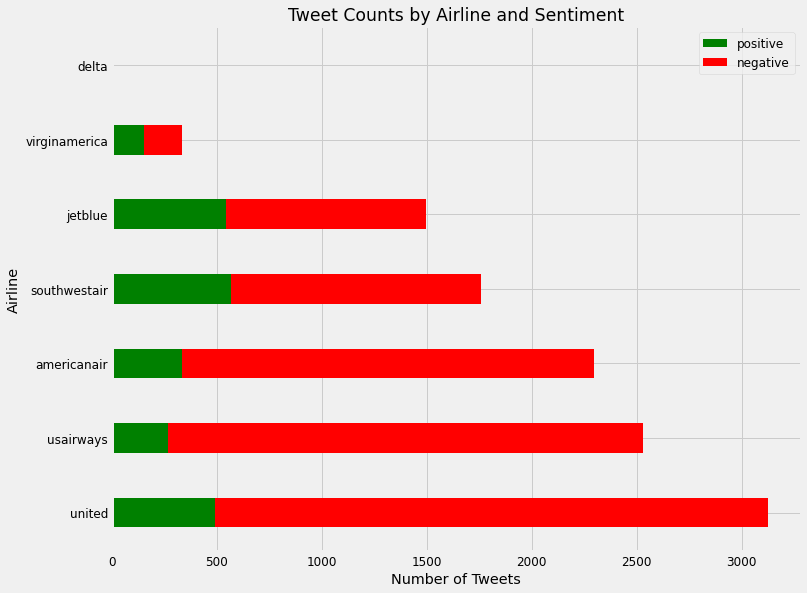

sentiment  Airline      
negative   united           2632
           usairways        2263
           americanair      1960
           southwestair     1187
           jetblue           953
           virginamerica     181
           delta               2
positive   southwestair      570
           jetblue           544
           united            492
           americanair       336
           usairways         269
           virginamerica     152
Name: Airline, dtype: int64

In [22]:
import matplotlib.style as style
style.use('fivethirtyeight')

airlineList = airline_df['Airline'].value_counts().index
N = len(airlineList)

posCount=[]
negCount=[]

for i in airlineList:
    posCount.append(posCountSeries[i])
    negCount.append(negCountSeries[i])
    
ind = np.arange(N)    # groups on x-axis
width = 0.4       # width of the bars

plt.rcParams['figure.figsize'] = [11, 9]
plt.rcParams.update({'font.size': 12})
p1 = plt.barh(ind, posCount, width, color='g')
p2 = plt.barh(ind, negCount, width, color='r',
             left=posCount)

plt.xlabel('Number of Tweets')
plt.ylabel('Airline')
plt.title('Tweet Counts by Airline and Sentiment')
plt.yticks(ind, airlineList)
plt.xticks(np.arange(0, 3201, 500))
plt.legend((p1[0], p2[0]), ('positive', 'negative'))

plt.show()
negPosCounts

Regarding the distribution of tweets of US airlines, United was tweeted about the most in the dataset provided, followed by US Airways, American Air, Southwest Air, Jet Blue, Virgin America, and Delta. United was tweeted about 3124 times, while Delta was only tweeted about twice.

Only 20.5% of all tweets regarding airlines were classified as having positive sentiment associated with it, indicating that  the majority of tweets pertained to airline complaints.

### Visualizing Airline Complaints
Each negative sentiment tweet in the airline dataset has a reason for complaint associated with it. We can generate a frequency plot of complaints to identify what areas of public service US airlines struggled with the most in 2015.

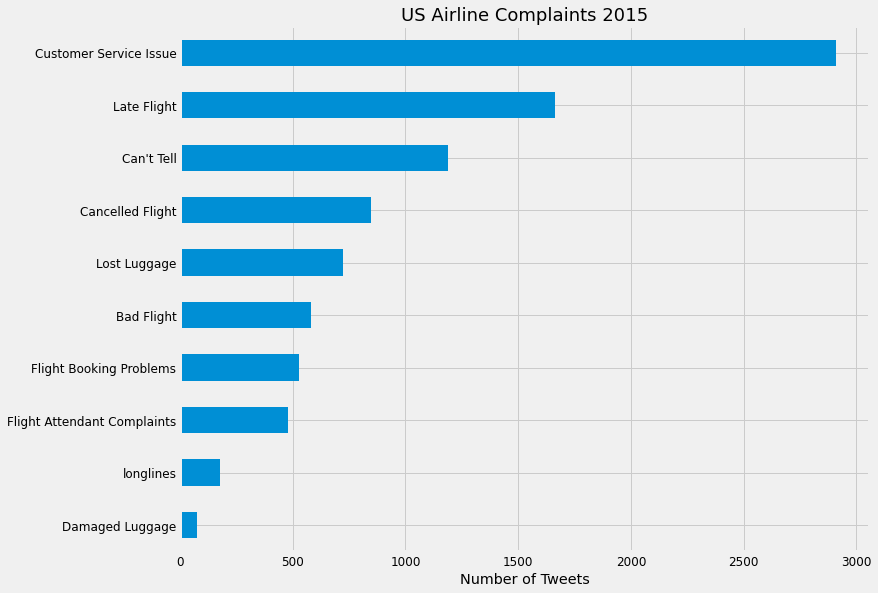

In [23]:
# Create new dataframe with only negative US airline tweets
negativeAirline_df = airline_df[airline_df['sentiment']=='negative']
# Count the number of tweets classified according to their negative reason
ax = negativeAirline_df['negative_reason'].value_counts(ascending=True).plot(kind='barh')
ax.set_title('US Airline Complaints 2015', fontsize=18)
ax.set_xlabel('Number of Tweets')
plt.show()

### Word Frequency for Airline Tweets
A word cloud displaying the reletive frequencies of the top 200 words in the US airline twitter dataset is presented. Larger words correspond to a higher frequency.

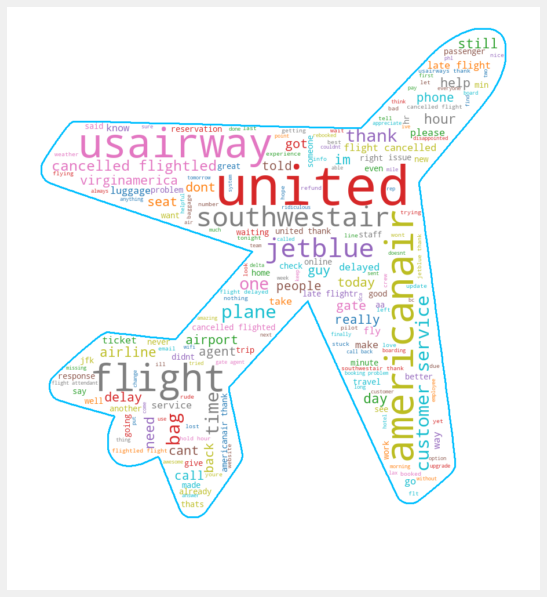

In [24]:
# Helper function for wordcloud generation
def generate_wordcloud(textSeries, mask_img):
    wcText = " ".join(tweet for tweet in textSeries)
    twitter_mask = np.array(Image.open(mask_img))
    twitter_mask[twitter_mask>240] = 255
    wordcloud = WordCloud(max_words=200,
                          background_color="white",
                          width=600,
                          height=600,
                          mask=twitter_mask,
                          colormap='tab10',
                          contour_color='deepskyblue',
                          contour_width=2
    ).generate(wcText)

    # Display the wordcloud
    plt.figure( figsize=(10,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Generate and display a wordcloud for airline tweets
plane_mask = os.path.join(pwd, 'misc', 'Planelogo_mask.png')
generate_wordcloud(airline_df['cleantext'], plane_mask)

A quick inspection of the wordcloud reveals that many of the tweets involve the following companies: United Airlines, US airways, and American Air. A significant proportion of the tweets pertain to customer service, delays, and flight cancellations.

### Twitter Word Frequencies
A word cloud displaying the reletive frequencies of the top 200 words in the generic tweet dataset is also presented below.

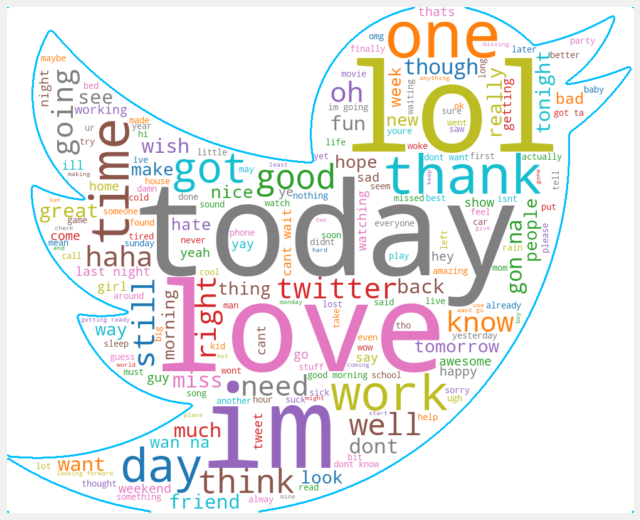

In [25]:
# Generate and display a wordcloud for all generic tweets
twitter_mask = os.path.join(pwd, 'misc', 'twitterlogo_mask.png')
generate_wordcloud(generic_df['cleantext'], twitter_mask)

From the word cloud, it is apparent that some of the most frequently mentioned words from the list of generic tweets are: love, lol, today, time, work, day, going. It appears many twitter users tend to tweet about their daily experiences, as well as things they like.

## Text Featurization and Model Selection
To prepare the data for input into our classification model, we need to featurize the text data into numerical inputs. One method of featurization would be to convert the text data into TF-IDF (term frequency-inverse document frequency) features. This representation allows each word to scale proportionally to the number of times it appears and inversely proportional to the number of times in appears in the corpus (different tweets). This is typically more robust than a simple word frequency (bag-of-words) model since the importance of a word decreases if it appears in more tweets.

Additionally, featurization using word embeddings will also be done. Word embeddings effectively encode each word with vectors, such that words with similar context have high cosine similarity (low angle between the vectors). Word embeddings are created via a shallow neural network model, with the trained weights of the neural net acting as the word vectors. Both a skip-gram (SG) and a continuous bag of words (CBOW) model will be explored. SG trains a single-hidden-layer neural network based on the task of given an input word, give us the predicted probability of other words appearing near the input. CBOW on the other hand takes multiple input context words to predict the probability of a single word appearing around the input words. The word vectors for each word in a tweet can then be averaged to obtain a single tweet vector embedding.

Extending word2vec, we can directly encode each tweet with a document vector using doc2vec. The distributed bag of words (DBOW) implementation of doc2vec uses the document vector to predict multiple words in the paragraph. The distributed memory (DM) implementation uses multiple context words in a window, as well as the document vector to prediction a single word. Since word and document embeddings take an unsupervised learning approach, it is common to learn the embeddings on as much relevant text data available without splitting data into a training and testing split.

Nine different featurizations will be tested for their performance:
- unigram TF-IDF
- bigram TF-IDF
- trigram TF-IDF
- unigram & bigram TF-IDF
- unigram & bigram & trigram TF-IDF
- word2vec skip-gram (SG)
- word2vec continuous bag of words (CBOW)
- doc2vec distributed bag of words (DBOW)
- doc2vec distributed memory (DM)
    


Before featurization, dataset is randomly split according to training data and test data. The training set will be used to fit our models and the testing set will be used to aid in the evaluation of model performance.

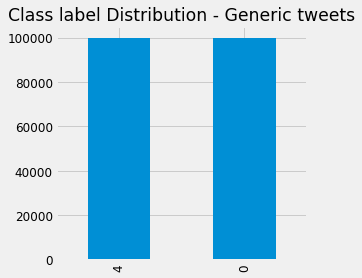

In [26]:
# Check if dataset is balanced
plt.figure(figsize=(4,4))
generic_df['class'].value_counts().plot(kind='bar')
plt.title('Class label Distribution - Generic tweets')
plt.show()

In [27]:
# Split data into Train / Test
cleanTweets = generic_df['cleantext']
tweetSentiments = generic_df['class']
X_train, X_test, y_train, y_test = train_test_split(cleanTweets, tweetSentiments,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=tweetSentiments)

In [28]:
####### Text Featurization of training data #######
X_train_featurizations = {}

### TF-IDF
def tfidf_featurize(X_untokenized):
    '''
    INPUT:
    X_untokenized : list/series of untokenized tweets
    ---------------------------------------------------    
    OUTPUT:
    featurizations : dict of tfidf fitted transformers and the transformed datasets
    '''
    min_df_ = 5
    max_features_ = 3000
    tfidf_ngrams = {
        'tfidf_1g':(1,1), # Unigram
        'tfidf_2g':(2,2), # Bigram
        'tfidf_3g':(3,3), # Trigram
        'tfidf_1g2g':(1,2), # Unigram + Bigram
        'tfidf_1g2g3g':(1,3), # Unigram + Bigram + Trigram
    } 
    
    featurizations = {} # Store function output
    for name, ngram_range_ in sorted(tfidf_ngrams.items()):
        tfidf_vectorizer = TfidfVectorizer(min_df=min_df_,
                                           max_features=max_features_,
                                           ngram_range=ngram_range_)
        X_transform = tfidf_vectorizer.fit_transform(X_untokenized)
        featurizations[name] = {'X': X_transform,
                               'transformer': tfidf_vectorizer}
    return featurizations

featurize_eval = tfidf_featurize(X_train)


In [29]:
### Word Embeddings - word2vec
def get_mean_wordVec(tokenized_tweet, model_wv, vecSize):
    ''' Returns the mean of the word vectors in a tokenized tweet'''
    avg_wordVec = np.zeros(vecSize).reshape((1, vecSize))
    count_inVocab = 0
    for token in tokenized_tweet:
        try:
            avg_wordVec += model_wv[token].reshape((1, vecSize))
            count_inVocab += 1
        except KeyError:
            continue #Case where token not in vocab
            
    if count_inVocab != 0:
        avg_wordVec /= count_inVocab
    return avg_wordVec


def w2v_featurize(X_untokenized, wordVecs):
    '''
    INPUT:
    X_untokenized : list/series of untokenized tweets to featurize with word2vec
    wordVecs : dict of one or more word2vec word mappings
    ---------------------------------------------------    
    OUTPUT:
    featurizations : dict of word2vec embedded data and word-to-vector mapping object(s)
    '''
    featurizations= {}
    for modelName, wv in wordVecs.items():
        vec_size = wv.vectors.shape[1]
        X_tokenized = X_untokenized.copy().str.split()
        
        # Average all the word vectors in a tweet to obtain a feature vector per tweet
        X_transform = X_tokenized.apply(get_mean_wordVec, args=(wv, vec_size))
        featurizations[modelName] = {'X': np.concatenate(X_transform.values),
                                     'wv': wv}
    return featurizations
    

def w2v_learn(X_untokenized):
    '''
    INPUT:
    X_untokenized : list/series of untokenized tweets
    ---------------------------------------------------    
    OUTPUT:
    wordVecs : dict of word2vec embedded data and word-to-vector mapping object
    '''
    wordVecs = {} # Store function output
    cores = multiprocessing.cpu_count()
    
    # word2vec (SG)
    # word2vec (CBOW)
    w2v_modelParams = {'w2v_SG': 1, 'w2v_CBOW': 0}
    vec_size = 100
    min_count_ = 2
    alpha_ = 0.030
    window_size = 2
    epochs_ = 90
    
    for modelName, is_sg in w2v_modelParams.items():
        X_tokenized = X_untokenized.copy().str.split()
        filename = modelName + '.kv'
        path = os.path.join(pwd, 'trained_embeddings', filename)
        wv=dict()
        try:
            wv = KeyedVectors.load(path, mmap='r') # Check if file saved in pwd
        except FileNotFoundError:
            # Train w2v Neural Net if no model saved
            w2v_model = Word2Vec(X_tokenized,
                                 size=vec_size,
                                 min_count=min_count_,
                                 alpha=alpha_,
                                 workers=cores,
                                 window=window_size,
                                 sg=is_sg)

            w2v_model.train(X_tokenized, total_examples=w2v_model.corpus_count, epochs=epochs_)
                        
            # Saving word vectors
            w2v_model.wv.save(path)
            wv = w2v_model.wv
            del w2v_model # delete model to free up memory
            
        wordVecs[modelName] = wv        
    return wordVecs



In [30]:
# Group all available tweets before learning wordVector embeddings
generic_df_flagged = generic_df.copy()[['cleantext','class']]
generic_df_flagged['isGeneric'] = 1
airline_df_flagged = airline_df.copy()[['cleantext','class']]
airline_df_flagged['isGeneric'] = 0
cleanTweets_all = pd.concat([generic_df_flagged, airline_df_flagged])
cleanTweets_all = shuffle(cleanTweets_all, random_state=12) # Shuffle prior to learning word embeddings
cleanTweets_all.head()

,cleantext,class,isGeneric
114920,@truedeadman hahaha know bay bay,4,1
174487,eastridge later,4,1
40946,@lucyfurleaps agree breast feeding got way go ...,0,1
135079,got phone @drkilstein awesome fella,4,1
55696,@daarken 55 isnt worth price increase @animal_...,0,1


In [31]:
# Learn w2v embeddings with all twitter data
wordVecs = w2v_learn(cleanTweets_all['cleantext'])

# Get w2v embeddings for X_train
w2v_feature_reps = w2v_featurize(X_train, wordVecs)

# Update dict with word2vec features
featurize_eval.update(w2v_feature_reps) 

In [32]:
featurize_eval['w2v_SG']['X'].shape

(160000, 100)

In [33]:
featurize_eval['w2v_CBOW']['X'].shape

(160000, 100)

In [34]:
### Document Embeddings - doc2vec
def d2v_learn_featurize(X_untokenized):
    '''
    INPUT:
    X_untokenized : list/series of untokenized tweets
    ---------------------------------------------------    
    OUTPUT:
    featurizations : dict of doc2vec embedded data and trained doc2vec models
    '''
    featurizations = {} # Store function output
    cores = multiprocessing.cpu_count()
    
    # doc2vec (DBOW)
    # doc2vec (DM)
    d2v_modelParams = {'d2v_DBOW': 0, 'd2v_DM': 1}
    vec_size = 100
    min_count_ = 2
    alpha_ = 0.030
    window_size = 2
    epochs_ = 90
    
    for modelName, is_dm in d2v_modelParams.items():
        filename = modelName + '.doc2vec'
        path = os.path.join(pwd, 'trained_embeddings', filename)
        d2v_model = None
        try:
            d2v_model = Doc2Vec.load(path) # Check if file saved in pwd
        except FileNotFoundError:
            # Train d2v Neural Net if no model saved
            tagged_docs = [TaggedDocument(words=tweet.split(), tags=[str(i)]) for i, tweet in enumerate(X_untokenized)]
            print("Initializing Model", modelName)
            d2v_model = Doc2Vec(tagged_docs,
                                vector_size=vec_size,
                                min_count=min_count_,
                                alpha=alpha_,
                                workers=cores,
                                window=window_size,
                                dm=is_dm)
            print("Training Model", modelName)
            d2v_model.train(tagged_docs, total_examples=d2v_model.corpus_count, epochs=epochs_)
            print("Done Training Model", modelName)
                        
            # Saving d2v model
            print("Saving Model", modelName)
            d2v_model.save(path)
                                 
        # Obtain trained document feature vectors for each tweet
        n_train = X_untokenized.shape[0]
        X_transform = np.empty((n_train, vec_size))
        for i in range(n_train):
            X_transform[i] = d2v_model.docvecs[str(i)]
        featurizations[modelName] = {'X': X_transform,
                                     'model': d2v_model}        
    return featurizations    


def infer_tweet_vector(X_untokenized, d2v_model):
    '''Returns the inferred vectors of a series of unseen documents given a trained doc2vec model'''
    X_tokenized = X_untokenized.copy().str.split()
    X_transform = X_tokenized.apply(d2v_model.infer_vector)
    return np.stack(X_transform.values)


In [35]:
# Learn d2v embeddings with all twitter data
d2v_feature_reps_allTweets = d2v_learn_featurize(cleanTweets_all['cleantext'])
d2v_feature_reps_eval = {}

d2v_generic_X_train = None
d2v_generic_X_test = None
d2v_airline_X = None

# Extract data splits' respective d2v features following shuffling
for model_name, feat_info in d2v_feature_reps_allTweets.items():
    d2v_feature_reps_eval[model_name] = {}
    d2v_features = pd.DataFrame(feat_info['X'])
    dim = feat_info['X'].shape[1]
    cleanTweets_all_temp = cleanTweets_all.copy().reset_index(drop=False) # reset index for proper concat
    cleanTweets_all_temp = pd.concat([cleanTweets_all_temp, d2v_features], axis=1)
    cleanTweets_all_temp = cleanTweets_all_temp.set_index('index') # set original index for referencing
    
    d2v_generic_train = cleanTweets_all_temp.loc[cleanTweets_all_temp['isGeneric']==1].loc[X_train.index]
    d2v_generic_X_train = d2v_generic_train.iloc[:,-dim:].to_numpy()
    
    d2v_generic_test = cleanTweets_all_temp.loc[cleanTweets_all_temp['isGeneric']==1].loc[X_test.index]
    d2v_generic_X_test = d2v_generic_test.iloc[:,-dim:].to_numpy()
    
    d2v_airline = cleanTweets_all_temp.loc[cleanTweets_all_temp['isGeneric']==0].sort_index()
    d2v_airline_X = d2v_airline.iloc[:,-dim:].to_numpy()
    
    d2v_feature_reps_eval[model_name]['model'] = feat_info['model']
    d2v_feature_reps_eval[model_name]['X'] = d2v_generic_X_train
    
    del cleanTweets_all_temp
    

featurize_eval.update(d2v_feature_reps_eval)


## Baseline Model Evaluation
Next, we will test the performance of a variety of different classification algorithms to see which ones perform the best on the features created. Namely, we will evaluate how well each classifier performs on each set of features prepared in the previous section. By spot-checking many different algorithms, we can avoid spending too much time tuning an algorithm with subpar performance.

Once we have identified the featurization and algorithm pair that seems the best suited for this sentiment analysis problem, we can invest more time towards in-depth feature selection and hyperparameter tuning to further improve classification accuracy.

In [37]:
# Initialize Baseline Models
def init_models():
    '''Returns a dict of initialized classifier models'''
    models = {}
    seed = 2
    
    # Linear
    models['LogReg'] = LogisticRegression(penalty='none', n_jobs=-1)
    C_vals = [0.1, 0.3, 0.6, 1.0]
    for inv_reg in C_vals:
        models['LR-L1-'+str(inv_reg)] = LogisticRegression(penalty='l1', C=inv_reg,
                                                           solver='saga', random_state=seed, n_jobs=-1)
        models['LR-L2-'+str(inv_reg)] = LogisticRegression(penalty='l2', C=inv_reg, n_jobs=-1)
        models['LR-eNet-'+str(inv_reg)] = LogisticRegression(penalty='elasticnet', C=inv_reg, l1_ratio=0.5,
                                                             solver='saga', random_state=seed, n_jobs=-1)

    alphas = [0.0001, 0.001, 0.01, 0.1]
    for reg in alphas:
        models['SGD-L1-'+str(reg)] = SGDClassifier(loss='hinge', penalty='l1', alpha=reg, random_state=seed, n_jobs=-1)
        models['SGD-L2-'+str(reg)] = SGDClassifier(loss='hinge', penalty='l2', alpha=reg, random_state=seed, n_jobs=-1)
        models['SGD-eNet-'+str(reg)] = SGDClassifier(loss='hinge', penalty='l2', alpha=reg, l1_ratio=0.5,
                                                     random_state=seed, n_jobs=-1)

    # NonLinear
    models['GaussianNB'] = GaussianNB()
    models['MultinomialNB'] = MultinomialNB()
    
    models['dTree'] = DecisionTreeClassifier()
    models['eTree'] = ExtraTreeClassifier(random_state=seed)

    for inv_reg in C_vals:
        models['SVC_lin-L1-'+str(inv_reg)] = LinearSVC(penalty='l1', C=inv_reg, dual=False)
        models['SVC_lin-L2-'+str(inv_reg)] = LinearSVC(penalty='l2', C=inv_reg, dual=False)
    
    hidden_layer_arch = [(16,16), (16,16,16), (64,32,16)]
    for arch in hidden_layer_arch:
        models['MLP-'+str(arch).replace(' ','')] = MLPClassifier(hidden_layer_sizes=arch)
    
    # Ensemble
    n_trees = 125
    models['gbTrees'] = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_trees, max_depth=5,
                                          colsample_bytree = 0.6, alpha = 5,
                                          learning_rate=0.1, random_state=seed)
    models['eTrees'] = ExtraTreesClassifier(n_estimators=n_trees, n_jobs=-1, random_state=seed)
    models['rForest'] = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1, random_state=seed)
    models['bagTrees'] = BaggingClassifier(n_estimators=n_trees, n_jobs=-1, random_state=seed)
    return models
    

base_models = init_models()


In [38]:
# Sparse to Dense Array transformer
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    def fit(self, X, y=None, **fit_params):
        return self

    
# Make pipeline for base model selection
def create_pipeline(model, X):
    pipeSteps = []
    # Convert to dense if sparse format
    if type(X) == csr_matrix:
        pipeSteps.append(('to_dense', DenseTransformer()))
    pipeSteps.append(('normalize', MinMaxScaler()))
    pipeSteps.append(('model', model))
    pipeline = Pipeline(pipeSteps)
    return pipeline


# Cross validate a single model on a feature set
def cross_val_model(model, X, y, n_folds, scorer):
    pipe = create_pipeline(model, X)
    val_scores = cross_val_score(pipe, X, y, scoring=scorer, cv=n_folds, n_jobs=1)
    return val_scores


# Spot-checking: Returns Cross Validation scores for each model and featurization pair
def cv_models_features(models, featurizations, y, n_folds=4, scorer='accuracy'):
    filename = os.path.join(pwd, 'misc', 'cv_spotcheck_results.csv')
    try:
        raw_str_data = pd.read_csv(filename, index_col=0) # Load results if already saved
        # Numeric Data Type Conversion
        def list_to_numeric(str_list):
            x = str_list.strip("[]").split()
            return list(map(float, x))        
        cv_results = raw_str_data.applymap(list_to_numeric)
        
    except FileNotFoundError:
        featurizationNames = sorted(featurizations.keys())
        modelNames = sorted(models.keys())
        cv_results = pd.DataFrame(index=modelNames, columns=featurizationNames)
        
        # cross validate 
        for m_name in tqdm(modelNames):
            for f_name in tqdm(featurizationNames):
                X = featurizations[f_name]['X']
                model = models[m_name]
                cv_scores = cross_val_model(model, X, y, n_folds, scorer)
                cv_results.loc[m_name, f_name] = cv_scores  
                
        cv_results.to_csv(filename)  
    return cv_results


# Evaluate base models for each featurization
t0 = time.time()
spotcheck_results = cv_models_features(base_models, featurize_eval, y_train, n_folds=4, scorer='accuracy')
t1 = time.time()
print("time elapsed: {:.2f} sec".format(t1-t0))

time elapsed: 0.14 sec


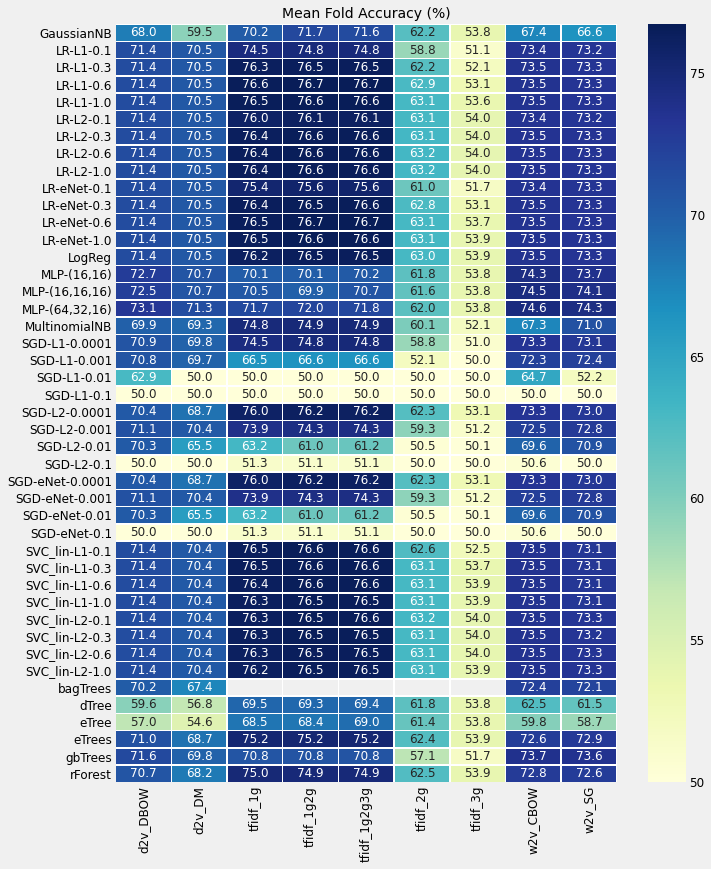

In [39]:
spotcheck_mean_acc = spotcheck_results.applymap(lambda x: np.mean(x)*100)

plt.figure(figsize=(10,13))
ax = sns.heatmap(spotcheck_mean_acc, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1f")
ax.set_title('Mean Fold Accuracy (%)', fontsize='14')
plt.show()

From the heatmap of cross-validated mean accuracy scores the following patterns are observed:
- Linear classifiers are superior to non-linear algorithms when tf-idf featurization is used.
- word2vec perform quite well for MLPs and gradient boosted trees
- doc2vec embeddings have poor performance overall

In [40]:
spotcheck_mean_acc['classifier'] = spotcheck_mean_acc.index

spotcheck_melt = spotcheck_mean_acc.melt(id_vars='classifier',
                                        var_name='feature',
                                        value_name='avg_acc')

# Filter set of best performing Algorithms
LR_spotcheck = spotcheck_melt[spotcheck_melt['classifier'].str.startswith('LR')]
best_LR = LR_spotcheck.loc[LR_spotcheck['avg_acc'].idxmax()]

SVC_spotcheck = spotcheck_melt[spotcheck_melt['classifier'].str.startswith('SVC')]
best_SVC = SVC_spotcheck.loc[SVC_spotcheck['avg_acc'].idxmax()]

MLP_spotcheck = spotcheck_melt[spotcheck_melt['classifier'].str.startswith('MLP')]
best_MLP = MLP_spotcheck.loc[MLP_spotcheck['avg_acc'].idxmax()]

gbTrees_spotcheck = spotcheck_melt[spotcheck_melt['classifier']=='gbTrees']
best_gbTrees = gbTrees_spotcheck.loc[gbTrees_spotcheck['avg_acc'].idxmax()]

good_spotchecks = pd.DataFrame([best_LR, best_SVC, best_MLP, best_gbTrees]).sort_values(by='avg_acc', ascending=False)
good_spotchecks.reset_index(inplace=True)
good_spotcheck_cv_accs = []
for row in good_spotchecks.iterrows():
    classifier = row[1].loc['classifier']
    feature = row[1].loc['feature']
    good_spotcheck_cv_accs.append(spotcheck_results.loc[classifier, feature] * 100)

good_spotchecks

,index,classifier,feature,avg_acc
0,179,LR-L1-0.6,tfidf_1g2g3g,76.706250
1,163,SVC_lin-L1-0.3,tfidf_1g2g,76.601875
2,324,"MLP-(64,32,16)",w2v_CBOW,74.606250
3,350,gbTrees,w2v_CBOW,73.688750


In [41]:
cv_accs = pd.DataFrame(good_spotcheck_cv_accs)
good_spotchecks_cv_accs = pd.concat([good_spotchecks, cv_accs], axis=1)
good_spotchecks_cv_accs['classifier & feature'] = good_spotchecks['classifier'] + ' + ' + good_spotchecks['feature']
good_spotchecks_cv_accs.drop(['index', 'classifier', 'feature', 'avg_acc'], axis=1, inplace=True)

good_spotchecks_cv_accs = good_spotchecks_cv_accs.melt(id_vars='classifier & feature',
                                                       var_name = 'Fold',
                                                       value_name='Fold Accuracy')

good_spotchecks_cv_accs.sort_values(['classifier & feature','Fold'], inplace=True)
good_spotchecks_cv_accs

,classifier & feature,Fold,Fold Accuracy
0,LR-L1-0.6 + tfidf_1g2g3g,0,0.766075
4,LR-L1-0.6 + tfidf_1g2g3g,1,0.770700
8,LR-L1-0.6 + tfidf_1g2g3g,2,0.766950
12,LR-L1-0.6 + tfidf_1g2g3g,3,0.764525
16,LR-L1-0.6 + tfidf_1g2g3g,4,0.766075
...,...,...,...
1583,gbTrees + w2v_CBOW,395,0.738000
1587,gbTrees + w2v_CBOW,396,0.735325
1591,gbTrees + w2v_CBOW,397,0.741525
1595,gbTrees + w2v_CBOW,398,0.732700


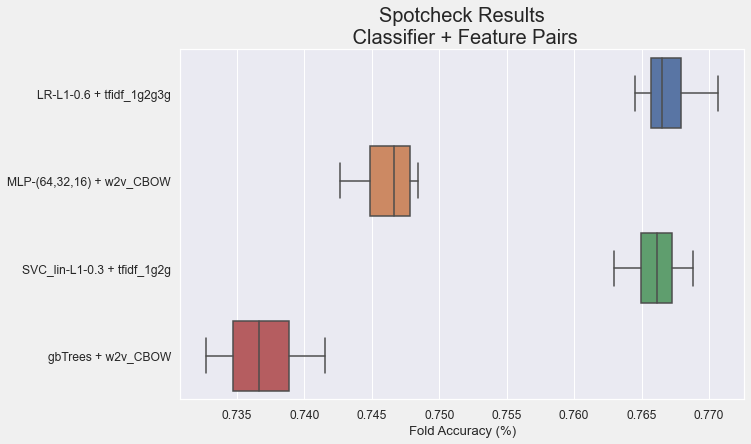

In [42]:
# Boxplots of Cross-val accuracies
plt.figure(figsize=(9,6))
sns.set(font_scale = 1.1)
ax = sns.boxplot(y='classifier & feature', x="Fold Accuracy", data=good_spotchecks_cv_accs)
ax.set_xlabel('Fold Accuracy (%)')
ax.set_ylabel('')
ax.set_title('Spotcheck Results\n Classifier + Feature Pairs', fontsize=20)
plt.show()

From the results presented, logistic regression and support vector classifiers achieve the highest accuracy. I believe neural nets and gradient boosted tree algorithms are worth investigating in more detail since their performance is highly dependent on the selection of architecture and hyperparameters.

The following will be investigated in more detail:
- Tune a linear classifier on tf-idf features (up to 3 grams). Includes selecting parameters for featurization, feature scaling technique, feature selection technique, and model hyperparameters.
- Try [pre-trained GloVe word embeddings](https://nlp.stanford.edu/projects/glove/) on twitter data
- Tune gradient boosted trees hyperparameters with word embeddings (word2vec / GloVe).
- Experiment with different Convolutional Neural Net (CNN) architectures alongside word embeddings (word2vec / GloVe / embedding input layer).

### Linear Classifier Tuning
Based on their baseline performance, we will train a logistic classifier with tf-idf features (up to and including trigrams) in this section. Since model performance is dependent on selecting prominent features, parameters controlling the number of features, scaling of features, and selection of features will be tuned, in addition to model hyperparameters.

In [43]:
## Lasso Regression (L1 penalty)

# Optimize tf-idf vectorizer independently
max_features_ = [3000, 10000, 50000, 100000]
val_accs_lr_tfidf = []
save_as = os.path.join(pwd, 'misc', 'val_accs_lr_tfidf.pkl')

try:
    with open(save_as, 'rb') as f:
        val_accs_lr_tfidf = pickle.load(f)

except (FileNotFoundError, EOFError):
    for max_f in tqdm(max_features_):  
        tfidf_vectorizer = TfidfVectorizer(
            min_df=5,
            max_features=max_f,
            ngram_range=(1,3)
        )

        lr = LogisticRegression(penalty='l1', C=0.6, solver='saga', max_iter=200,
                                random_state=181, n_jobs=-1)
        
        pipeSteps = []
        pipeSteps.append(('tfidf', tfidf_vectorizer))
        pipeSteps.append(('normalize', MaxAbsScaler())) #Scaler can be applied to Sparse; similar to minmax for pos values
        pipeSteps.append(('model', lr))
        pipeline = Pipeline(pipeSteps)
        val_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        val_accs_lr_tfidf.append(np.mean(val_scores))
    
    with open(save_as, 'wb') as f:
        pickle.dump(val_accs_lr_tfidf, f)

In [44]:
print(val_accs_lr_tfidf)

[0.7666124999999999, 0.77378125, 0.77431875, 0.77431875]


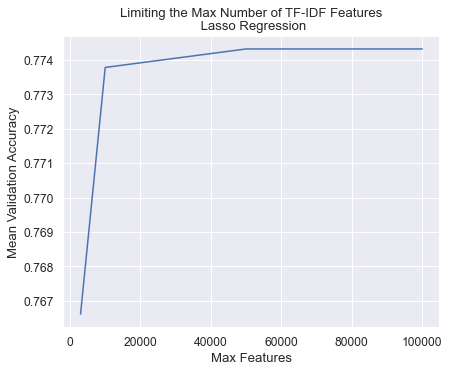

In [45]:
# Plot results
plt.figure(figsize=(6,5))
plt.plot(max_features_, val_accs_lr_tfidf)
plt.title('Limiting the Max Number of TF-IDF Features\n Lasso Regression')
plt.xlabel('Max Features')
plt.ylabel('Mean Validation Accuracy')
plt.show()

It appears that by including more features, we are able to achieve a small 1% boost in accuracy averaged over 4-fold of validation. The accuracy does not improve beyond setting 50000 as the maximum number of tf-idf features, so we'll use that as the limit when selecting a feature scaler.

In [48]:
# Select Feature Scaler Indepedently

# Scalers which support sparse input
scalers = {'MaxAbs': MaxAbsScaler(),
           'Standard': StandardScaler(with_mean=False),
           'Robust': RobustScaler(with_centering=False)}

scaler_names = sorted(scalers.keys())
val_accs_lr_scaler = []
save_as = os.path.join(pwd, 'misc', 'val_accs_lr_scaler.pkl')

try:
    with open(save_as, 'rb') as f:
        val_accs_lr_scaler = pickle.load(f)
    
except (FileNotFoundError, EOFError):
    for name, scaler in tqdm(sorted(scalers.items())):
        lr = LogisticRegression(penalty='l1', C=0.6, solver='saga', max_iter=200,
                                random_state=181, n_jobs=-1)
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=50000, ngram_range=(1,3))
        pipeSteps = []
        pipeSteps.append(('tfidf', tfidf_vectorizer))
        pipeSteps.append((name, scaler))
        pipeSteps.append(('model', lr))
        pipeline = Pipeline(pipeSteps)

        val_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        val_accs_lr_scaler.append(np.mean(val_scores))

    with open(save_as, 'wb') as f:
        pickle.dump(val_accs_lr_scaler, f)


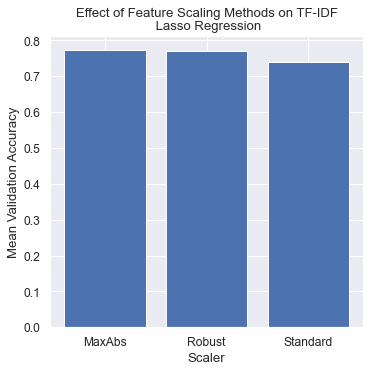

In [49]:
# Plot results
plt.figure(figsize=(5,5))
plt.bar(scaler_names, val_accs_lr_scaler)
plt.title('Effect of Feature Scaling Methods on TF-IDF\n Lasso Regression')
plt.xlabel('Scaler')
plt.ylabel('Mean Validation Accuracy')
plt.show()

Results show that the `MaxAbsScaler` results in the highest mean cross-validated accuracy for the same features and model.

Next we will be investigate the effect of different feature scaling methods. In sklearn, two feature selection methods which provide support for sparse matrix data in classification problems are `chi2` and `mutual_info_classif`. Both measure the dependency between two random variables (a feature and the target variable), allowing for the selection of the features yielding the highest scores. Both feature selection techniques are compared to the case of simply limiting the number of tf-idf features during vectorization.

In [50]:
# Select feature selection method independently
feature_limits = np.arange(10000,110000,10000)
save_as = os.path.join(pwd, 'misc', 'feature_select_lr_accs.csv') 

try:
    feature_select_accs = pd.read_csv(save_as)

except FileNotFoundError:
    tfidf_accs = []
    chi2_accs = []
    mutualInfo_accs = []
    for lim in tqdm(feature_limits):
        lr = LogisticRegression(penalty='l1', C=0.6, solver='saga', max_iter=200,
                                random_state=181, n_jobs=-1)

        scaler = MaxAbsScaler()

        # TF-IDF feature limiting
        tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=lim, ngram_range=(1,3))

        pipeSteps = []
        pipeSteps.append(('tfidf', tfidf_vectorizer))
        pipeSteps.append(('scaler', scaler))
        pipeSteps.append(('model', lr))
        tfidf_pipe = Pipeline(pipeSteps)

        tfidf_val_scores = cross_val_score(tfidf_pipe, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        tfidf_mean_acc = np.mean(tfidf_val_scores)
        tfidf_accs.append(tfidf_mean_acc)

        # Chi2
        tfidf_all = TfidfVectorizer(min_df=2, ngram_range=(1,3))

        chi2_pipe = Pipeline([
            ('tfidf', tfidf_all),
            ('scaler', scaler),
            ('feat_selection', SelectKBest(chi2, k=lim)),
            ('model', lr)
        ])
        chi2_val_scores = cross_val_score(chi2_pipe, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        chi2_mean_acc = np.mean(chi2_val_scores)
        chi2_accs.append(chi2_mean_acc)

        # Mutual Info
        MI_pipe = Pipeline([
            ('tfidf', tfidf_all),
            ('scaler', scaler),
            ('feat_selection', SelectKBest(mutual_info_classif, k=lim)),
            ('model', lr)
        ])
        MI_val_scores = cross_val_score(MI_pipe, X_train, y_train, scoring='accuracy', cv=4, n_jobs=-1)
        MI_mean_acc = np.mean(MI_val_scores)
        mutualInfo_accs.append(MI_mean_acc)

    feature_select_accs = pd.DataFrame({
        'Number of Limited Features': feature_limits,
        'tf-idf':tfidf_accs,
        'chi2':chi2_accs,
        'mutual info':mutualInfo_accs
    })

    feature_select_accs.to_csv(save_as)


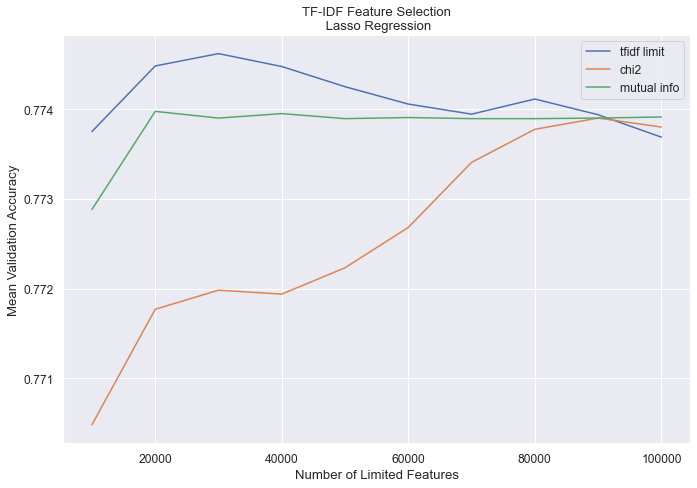

In [51]:
# Plot results
plt.figure(figsize=(10,7))
plt.plot(feature_select_accs['Number of Limited Features'], feature_select_accs['tf-idf'], label='tfidf limit')
plt.plot(feature_select_accs['Number of Limited Features'], feature_select_accs['chi2'], label='chi2')
plt.plot(feature_select_accs['Number of Limited Features'], feature_select_accs['mutual info'], label='mutual info')
plt.title('TF-IDF Feature Selection\n Lasso Regression')
plt.xlabel('Number of Limited Features')
plt.ylabel('Mean Validation Accuracy')
plt.legend()
plt.show()

From the plot, we find that simply limiting the number of features to the 30000 most frequently occurring grams yields the best accuracy. The feature selection methods are only effective beyond 90000 features in this instance.

In [52]:
# Model Hyperparamater tuning
fileName = os.path.join(pwd, 'models', 'lr_final.pkl')

try:
    lr_final = joblib.load(fileName)
    
except FileNotFoundError:
    tfidf_vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,3))
    scaler = MaxAbsScaler()
    clf = LogisticRegression(penalty='l1', solver='saga', max_iter=200, n_jobs=-1)

    lr_tune_pipe = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('maxAbs', scaler),
        ('lr', clf)
    ])

    param_grid = {
        'tfidf__min_df':[2,3],
        'lr__C':np.arange(0.55, 0.85, 0.05)
    }

    lr_final = GridSearchCV(lr_tune_pipe, param_grid, scoring='accuracy', cv=4,
                           n_jobs=-1, verbose=2)

    lr_final.fit(X_train, y_train) # Best found model is fit on entire train set
    joblib.dump(lr_final, fileName)

D:\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MaxAbsScaler from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking c

Best-Found Logistic Regression: Generic tweet test set 
------------------------------------------------------------------------------------------
best hyperparameters: {'lr__C': 0.8000000000000003, 'tfidf__min_df': 3}
k-fold validation acc: 0.7757125
test acc: 0.777525
ROC AUC: 0.777525
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     20000
           4       0.76      0.81      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



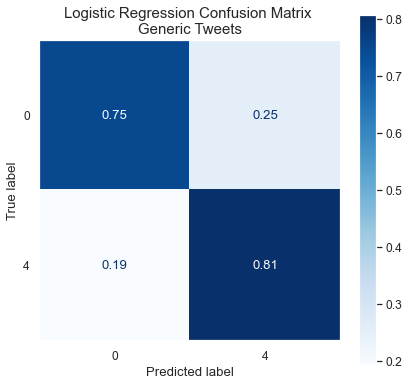

In [53]:
### Logistic Regression Performance statistics on generic test-set

print('Best-Found Logistic Regression: Generic tweet test set \n'+'-'*90)
print('best hyperparameters:', lr_final.best_params_)
print('k-fold validation acc:', lr_final.best_score_)
lr_test_preds = lr_final.predict(X_test)
lr_testacc_generic = accuracy_score(y_test, lr_test_preds)
auc_lr_generic = roc_auc_score(y_test,lr_test_preds)
print('test acc:', lr_testacc_generic)
print('ROC AUC:', auc_lr_generic)
print(classification_report(y_test,lr_test_preds))

fig, ax = plt.subplots(figsize=(6,6))

lr_cm = plot_confusion_matrix(lr_final, X_test, y_test,
                              cmap=plt.cm.Blues,
                              normalize='true',
                              ax=ax)

lr_cm.ax_.set_title('Logistic Regression Confusion Matrix \nGeneric Tweets', fontsize=15)
plt.grid(False)
plt.show()

Best-Found Logistic Regression: Airline tweet test set 
------------------------------------------------------------------------------------------
test acc: 0.760679317216879
ROC AUC: 0.8075811613024836
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      9178
           4       0.46      0.89      0.60      2363

    accuracy                           0.76     11541
   macro avg       0.71      0.81      0.72     11541
weighted avg       0.86      0.76      0.78     11541



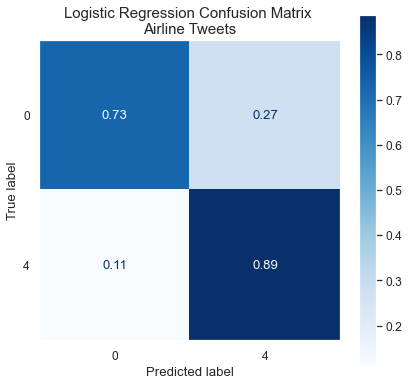

In [54]:
### Logistic Regression Performance statistics on airline test-set

print('Best-Found Logistic Regression: Airline tweet test set \n'+'-'*90)

X_test_airline = airline_df['cleantext']
y_test_airline = airline_df['class']

lr_test_preds = lr_final.predict(X_test_airline)
lr_testacc_airline = accuracy_score(y_test_airline, lr_test_preds)
auc_lr_airline = roc_auc_score(y_test_airline, lr_test_preds)
print('test acc:', lr_testacc_airline)
print('ROC AUC:', auc_lr_airline)
print(classification_report(y_test_airline,lr_test_preds))

fig, ax = plt.subplots(figsize=(6,6))

lr_cm = plot_confusion_matrix(lr_final, X_test_airline, y_test_airline,
                              ax=ax,
                              cmap=plt.cm.Blues,
                              normalize='true') #since airline data is imbalanced
lr_cm.ax_.set_title('Logistic Regression Confusion Matrix \nAirline Tweets', fontsize=15)
plt.grid(False)
plt.show()

After the selection of the best-found logistic regression model, we find that it achieves a test accuracy of 77.8% and a ROC area under curve (AUC) of 0.778, and a F1-score of ~0.78 for both classes on the generic tweet test set.

The performance of this model was also tested on the dataset of airline tweets which was unseen during training. By testing the model on a different set of twitter data, we can evaluate the robustness of our model. We find that on the airline tweet dataset, the logistic regression model achieves on accuracy of 76.1% and a ROC AUC of 0.808, which is quite good. Normalization of the confusion matrix shows that the classifier is quite precise at identifying negative airline tweets and great recall for positive tweets, even though it was trained on balanced data. In fact, a precision of 0.96 was achieved for the negative sentiment class on the airline dataset. A good f1-score of 0.83 is also achieved for the negative class. This model would be good for airline companies which would like to effectively filter new tweets for customer complaints since it provides high precision and decent recall for tweets of negative sentiment.

### Gradient Boosted Trees Tuning
Considering that the performance of tree models is typically highly sensitive based on their selected hyperparameters, careful tuning of an xgboost model should warrant additional investigation, despite performing much worse than linear models in terms of accuracy in the baseline test. The performance of GBTs will only be evaluated on word embedding featurizations, since its performance on tf-idf and doc2vec was poor.

First we will consider tuning the model on the previously trained 100-dimensional word2vec CBOW implementation.

#### Word2vec 100d

In [55]:
# word2vec feature transformer
def w2vTransformer(X_untokenized, wordvecs):
    if type(wordvecs) == dict:
        akey = list(wordvecs.keys())[0]
        vec_size = len(wordvecs[akey])        
    else:
        vec_size = wordvecs.vectors.shape[1]
    X_tokenized = X_untokenized.copy().str.split()
    X_transform = X_tokenized.apply(get_mean_wordVec, args=(wordvecs, vec_size))
    X_transform = np.concatenate(X_transform.values)
    return X_transform

In [56]:
## xgboost hyperparameter tuning - 100dim word2vec CBOW
xgb_fileName = os.path.join(pwd, 'models', 'xgb_100d_w2v.pkl') 
kv_path = os.path.join(pwd, 'trained_embeddings', 'w2v_CBOW.kv')
wv = KeyedVectors.load(kv_path, mmap='r')

try:
    xgb_100d_w2v = joblib.load(xgb_fileName)
    
except FileNotFoundError:
    X_train_100d_w2v = w2vTransformer(X_train, wv)
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'learning_rate': np.linspace(0.05, 0.2, 11),
        'max_depth': np.arange(4, 16),
        'subsample': np.linspace(0.6, 1, 11),
        'colsample_bytree': np.linspace(0.6, 0.9, 11),
        'gamma': [0, 0.025, 0.050, 0.075, 0.1],
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5, 10, 100],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 5, 10, 100]
    }
    
    xgb_100d_w2v = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=250,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=3)
    
    xgb_100d_w2v.fit(X_train_100d_w2v, y_train)
    joblib.dump(xgb_100d_w2v, xgb_fileName)

    
print('Best-Found GBT, w2v 100d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb_100d_w2v.best_params_)
print('k-fold validation acc:', xgb_100d_w2v.best_score_)
X_test_100d_w2v = w2vTransformer(X_test, wv)
xgb_100d_w2v_test_preds = xgb_100d_w2v.predict(X_test_100d_w2v)
xgb_100d_w2v_testacc = accuracy_score(y_test, xgb_100d_w2v_test_preds)
print('test acc:', xgb_100d_w2v_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb_100d_w2v_test_preds))
print(classification_report(y_test, xgb_100d_w2v_test_preds))    

Best-Found GBT, w2v 100d: Generic tweets 
------------------------------------------------------------------------------------------
best hyperparameters: {'subsample': 1.0, 'reg_lambda': 100, 'reg_alpha': 10, 'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.09500000000000001, 'gamma': 0.1, 'colsample_bytree': 0.6}
k-fold validation acc: 0.7506375
test acc: 0.749925
ROC AUC: 0.749925
              precision    recall  f1-score   support

           0       0.75      0.74      0.75     20000
           4       0.75      0.76      0.75     20000

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



In [57]:
pd.DataFrame(xgb_100d_w2v.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
17,865.598401,5.178588,1.191268,0.047653,1,100,10,300,13,0.095,0.1,0.6,"{'subsample': 1.0, 'reg_lambda': 100, 'reg_alp...",0.750350,0.754025,0.746800,0.751375,0.750637,0.002590,1
178,757.795356,0.769659,0.929680,0.074256,0.72,100,0.1,250,12,0.11,0.05,0.78,"{'subsample': 0.72, 'reg_lambda': 100, 'reg_al...",0.749325,0.754250,0.747425,0.747775,0.749694,0.002726,2
18,963.610708,3.209394,1.233741,0.148745,0.92,0.1,10,250,14,0.05,0.075,0.78,"{'subsample': 0.9199999999999999, 'reg_lambda'...",0.749675,0.753600,0.746475,0.748825,0.749644,0.002567,3
72,667.691443,6.510147,0.815249,0.107858,0.8,5,10,300,10,0.08,0.05,0.69,"{'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha...",0.749250,0.752000,0.747350,0.749025,0.749406,0.001668,4
43,1077.321373,12.730502,1.302701,0.180766,0.88,1,5,300,12,0.065,0.025,0.87,"{'subsample': 0.88, 'reg_lambda': 1, 'reg_alph...",0.749775,0.752500,0.745400,0.749900,0.749394,0.002550,5


With hyperparameter tuning, we are able to achieve a validation accuracy of 0.75, which is a big improvement from the untuned model. Examining the best performing models during cross validation, we find that they all have a large number of estimators in the hyperparameter search space defined. As a result, we can refine our tuning of hyperparameters to include more boosting stages.

In [58]:
## xgboost hyperparameter tuning (finer tuning) - 100dim word2vec CBOW
xgb2_fileName = os.path.join(pwd, 'models', 'xgb2_100d_w2v.pkl') 
kv_path = os.path.join(pwd, 'trained_embeddings', 'w2v_CBOW.kv')
wv = KeyedVectors.load(kv_path, mmap='r')

try:
    xgb2_100d_w2v = joblib.load(xgb2_fileName)
    
except FileNotFoundError:
    X_train_100d_w2v = w2vTransformer(X_train, wv)
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [300, 400, 500, 600, 700],
        'learning_rate': np.linspace(0.01, 0.1, 11),
        'max_depth': np.arange(10, 17),
        'subsample': np.linspace(0.8, 1, 11),
        'colsample_bytree': np.linspace(0.6, 0.8, 11),
        'gamma': np.linspace(0.05, 0.2, 11),
        'reg_alpha': np.linspace(0.1, 20, 11),
        'reg_lambda': np.linspace(0.1, 150, 21)
    }
    
    xgb2_100d_w2v = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=80,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=4)
    
    xgb2_100d_w2v.fit(X_train_100d_w2v, y_train)
    joblib.dump(xgb2_100d_w2v, xgb2_fileName)
    

print('Best-Found GBT, w2v 100d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb2_100d_w2v.best_params_)
print('k-fold validation acc:', xgb2_100d_w2v.best_score_)
X_test_100d_w2v = w2vTransformer(X_test, wv)
xgb2_100d_w2v_test_preds = xgb2_100d_w2v.predict(X_test_100d_w2v)
xgb2_100d_w2v_testacc = accuracy_score(y_test, xgb2_100d_w2v_test_preds)
print('test acc:', xgb2_100d_w2v_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb2_100d_w2v_test_preds))
print(classification_report(y_test, xgb2_100d_w2v_test_preds))

Best-Found GBT, w2v 100d: Generic tweets 
------------------------------------------------------------------------------------------
best hyperparameters: {'subsample': 0.88, 'reg_lambda': 52.565000000000005, 'reg_alpha': 4.079999999999999, 'n_estimators': 700, 'max_depth': 15, 'learning_rate': 0.05500000000000001, 'gamma': 0.08000000000000002, 'colsample_bytree': 0.76}
k-fold validation acc: 0.752925
test acc: 0.755075
ROC AUC: 0.755075
              precision    recall  f1-score   support

           0       0.76      0.75      0.75     20000
           4       0.75      0.76      0.76     20000

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



Using more than double the number of estimators allows the GBT to achieve a slight boost in performance, however it still fails to outperform our logistic regression model. Increasing the number of estimators beyond this would be too costly in terms of computational resources.

#### GloVe 100d
As an alternative to word2vec embeddings, we will assess the performance of 100 dimensional GloVe embeddings pre-trained on tweets.

In [59]:
### Import GloVe 100 dim
glove100_wv = {}   #Maps GloVe tokens to embedding vecs
glove100_path = 'D:\\Jason\\Documents\\glove_twitter\\glove.twitter.27B.100d.txt'

with open(glove100_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        wordVec =  np.asarray(values[1:], dtype='float32')
        glove100_wv[word] = wordVec

print('Number of word vectors: ', len(glove100_wv))

X_train_100d_glv = w2vTransformer(X_train, glove100_wv)

print(X_train_100d_glv.shape)

Number of word vectors:  1193514
(160000, 100)


In [60]:
## xgboost hyperparameter tuning - 100dim GLoVe
xgb_fileName = os.path.join(pwd, 'models', 'xgb_100d_glv.pkl') 

try:
    xgb_100d_glv = joblib.load(xgb_fileName)
    
except FileNotFoundError:
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [200, 300, 400, 500, 600],
        'learning_rate': np.linspace(0.01, 0.1, 11),
        'max_depth': np.arange(8, 17),
        'subsample': np.linspace(0.7, 0.9, 11),
        'colsample_bytree': np.linspace(0.6, 0.9, 11),
        'gamma': np.linspace(0, 0.2, 21),
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
    }
    
    xgb_100d_glv = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=100,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=10)
    
    xgb_100d_glv.fit(X_train_100d_glv, y_train)
    joblib.dump(xgb_100d_glv, xgb_fileName)
    

print('Best-Found GBT, GloVe 100d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb_100d_glv.best_params_)
print('k-fold validation acc:', xgb_100d_glv.best_score_)
X_test_100d_glv = w2vTransformer(X_test, glove100_wv)
xgb_100d_glv_test_preds = xgb_100d_glv.predict(X_test_100d_glv)
xgb_100d_glv_testacc = accuracy_score(y_test, xgb_100d_glv_test_preds)
print('test acc:', xgb_100d_glv_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb_100d_glv_test_preds))
print(classification_report(y_test, xgb_100d_glv_test_preds))


Best-Found GBT, GloVe 100d: Generic tweets 
------------------------------------------------------------------------------------------
best hyperparameters: {'subsample': 0.8200000000000001, 'reg_lambda': 100, 'reg_alpha': 5, 'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.05500000000000001, 'gamma': 0.16, 'colsample_bytree': 0.8700000000000001}
k-fold validation acc: 0.75263125
test acc: 0.75285
ROC AUC: 0.75285
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     20000
           4       0.75      0.76      0.76     20000

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



In [61]:
pd.DataFrame(xgb_100d_glv.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
56,1886.274062,10.980206,1.926816,0.262177,0.82,100,5,600,9,0.055,0.16,0.87,"{'subsample': 0.8200000000000001, 'reg_lambda'...",0.752625,0.755050,0.749600,0.753250,0.752631,0.001964,1
77,3095.857207,30.388187,6.447790,1.498953,0.9,50,0.001,600,14,0.1,0.1,0.78,"{'subsample': 0.9, 'reg_lambda': 50, 'reg_alph...",0.753625,0.755025,0.749175,0.752325,0.752537,0.002163,2
12,2706.880852,19.382256,5.189312,0.206940,0.72,100,1,600,13,0.064,0,0.81,"{'subsample': 0.72, 'reg_lambda': 100, 'reg_al...",0.753825,0.755075,0.750175,0.750525,0.752400,0.002101,3
28,1882.072392,64.049836,3.320710,0.140846,0.9,0.01,10,500,13,0.046,0.08,0.63,"{'subsample': 0.9, 'reg_lambda': 0.01, 'reg_al...",0.752600,0.754400,0.750550,0.750875,0.752106,0.001536,4
2,1782.362378,7.130546,1.608763,0.265378,0.86,1,50,600,11,0.091,0.13,0.75,"{'subsample': 0.86, 'reg_lambda': 1, 'reg_alph...",0.754000,0.753550,0.749575,0.750550,0.751919,0.001895,5


We find that the best GBT model trained on 100d GloVe embeddings achieves slightly lower validation and test accuracy than the 100d word2vec GBT model. A closer look at the fold validation scores, we find that the model trained with GloVe has less variance in validation scores. To avoid expending additional computational effort into training a 200d word2vec embedding with negligible benefit, we will proceed by evaluating the performance of 200d GloVe embeddings to see if increasing the number of embedding features results in a boost of predictive performance for our GBT model.

#### GloVe 200d

In [62]:
### Import GloVe 200 dim
glove200_wv = {}   #Maps GloVe tokens to embedding vecs
glove200_path = 'D:\\Jason\\Documents\\glove_twitter\\glove.twitter.27B.200d.txt'

with open(glove200_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        wordVec =  np.asarray(values[1:], dtype='float32')
        glove200_wv[word] = wordVec

print('Number of word vectors: ', len(glove200_wv))

X_train_200d_glv = w2vTransformer(X_train, glove200_wv)
print(X_train_200d_glv.shape)

Number of word vectors:  1193514
(160000, 200)


In [63]:
## xgboost hyperparameter tuning - 200dim GLoVe
xgb_fileName = os.path.join(pwd, 'models', 'xgb_200d_glv.pkl')

try:
    xgb_200d_glv = joblib.load(xgb_fileName)
    
except FileNotFoundError:
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                n_jobs = multiprocessing.cpu_count(),
                                random_state=181)
    
    param_grid = {
        'n_estimators': [600, 700],
        'learning_rate': np.linspace(0.01, 0.1, 11),
        'max_depth': np.arange(7, 15),
        'subsample': np.linspace(0.7, 0.9, 11),
        'colsample_bytree': np.linspace(0.6, 0.9, 11),
        'gamma': np.linspace(0, 0.2, 21),
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
    }
    
    xgb_200d_glv = RandomizedSearchCV(xgb_clf, param_grid,
                                      scoring='accuracy',
                                      n_iter=60,
                                      cv=4,
                                      n_jobs=-1,
                                      verbose=10)
    
    xgb_200d_glv.fit(X_train_200d_glv, y_train)
    joblib.dump(xgb_200d_glv, xgb_fileName)
    

print('Best-Found GBT, GloVe 200d: Generic tweets \n'+'-'*90)
print('best hyperparameters:', xgb_200d_glv.best_params_)
print('k-fold validation acc:', xgb_200d_glv.best_score_)
X_test_200d_glv = w2vTransformer(X_test, glove200_wv)
xgb_200d_glv_test_preds = xgb_200d_glv.predict(X_test_200d_glv)
xgb_200d_glv_testacc = accuracy_score(y_test, xgb_200d_glv_test_preds)
print('test acc:', xgb_200d_glv_testacc)
print('ROC AUC:', roc_auc_score(y_test, xgb_200d_glv_test_preds))
print(classification_report(y_test, xgb_200d_glv_test_preds))


Best-Found GBT, GloVe 200d: Generic tweets 
------------------------------------------------------------------------------------------
best hyperparameters: {'subsample': 0.86, 'reg_lambda': 50, 'reg_alpha': 0, 'n_estimators': 600, 'max_depth': 14, 'learning_rate': 0.09100000000000001, 'gamma': 0.09, 'colsample_bytree': 0.78}
k-fold validation acc: 0.76233125
test acc: 0.760625
ROC AUC: 0.7606250000000001
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     20000
           4       0.75      0.77      0.76     20000

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



We find that increasing the dimensionality of the GloVe word embeddings does result in a small boost in test accuracy (76.06%), however we are still unable to outperform our basic logistic regression model.

### 1D ConvNet Tuning
Convolutional neural nets are perfect to apply to a problem of text sentiment classification since they are capable of extracting local information from different parts of text via the local connectivity inherent in their architecture. This allows the network to extract context features of word based on other words near them, independent of the word's location in a sequence of text.

#### Word2vec 100d

In [64]:
### 1D ConvNet + word2vec 100d sequential (not flattened with mean operation)

kv_path = os.path.join(pwd, 'trained_embeddings', 'w2v_CBOW.kv')
wv = KeyedVectors.load(kv_path, mmap='r')

# Data preprocessing for input to keras model
max_words = wv.vectors.shape[0]  #Vocab size
val_split = 0.2

tokenizer_w2v100d = Tokenizer(num_words=max_words)
tokenizer_w2v100d.fit_on_texts(X_train.tolist())
sequences = tokenizer_w2v100d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_w2v100d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
split_idx = int(labels.shape[0] * (1-val_split))
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

# Embedding word2vec weights matrix for embedding layer
embedding_dim = wv.vectors.shape[1]   #100 dimensional
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, seq_idx in word_index.items():
    if seq_idx < max_words:
        try:
            embedding_vec = wv[word]
            embedding_matrix[seq_idx] = embedding_vec
        except KeyError:
            pass  #if word not in vocab

# Standardize embedding matrix
embed_mean = np.mean(embedding_matrix, axis=0)
embed_std = np.std(embedding_matrix, axis=0)
embedding_matrix = (embedding_matrix - embed_mean) / embed_std

embedding_matrix = embedding_matrix.astype('float32')

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


In [65]:
## Load / Train model  
lr = 0.001
es_patience = 10
epochs = 100
batch_sz = 128
model_path = os.path.join(pwd, 'models', 'convNet_w2v100d.h5')
model_history_path = os.path.join(pwd, 'models', 'convNet_w2v100d_history.pkl')

try:
    # Load existing model & training history
    convNet_w2v100d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_w2v100d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    convNet_w2v100d = models.Sequential()
    convNet_w2v100d.add(layers.Embedding(max_words, embedding_dim, input_length=data.shape[1]))
    convNet_w2v100d.add(layers.Dropout(0.5)) 
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.MaxPool1D(2))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_w2v100d.add(layers.Flatten())
    convNet_w2v100d.add(layers.Dense(512, activation='relu'))
    convNet_w2v100d.add(layers.Dense(512, activation='relu'))
    convNet_w2v100d.add(layers.Dropout(0.4))
    convNet_w2v100d.add(layers.Dense(1, activation='sigmoid'))

    # SET weights for embedding layer - already trained w2v
    convNet_w2v100d.layers[0].set_weights([embedding_matrix])
    convNet_w2v100d.layers[0].trainable = False

    print(convNet_w2v100d.summary())
    
    convNet_w2v100d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_w2v100d_history = convNet_w2v100d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_w2v100d_history = convNet_w2v100d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_w2v100d_history, file)

In [66]:
# Plotting function for neural net training history
def plot_train_history(history, subtitle=''):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(acc)+1)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].plot(epochs, acc, 'bo', label='Training acc')
    ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[0].set_title('Accuracy\n'+subtitle)
    ax[0].set_xlabel('Epochs')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Cross-Entropy Loss\n'+subtitle)
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

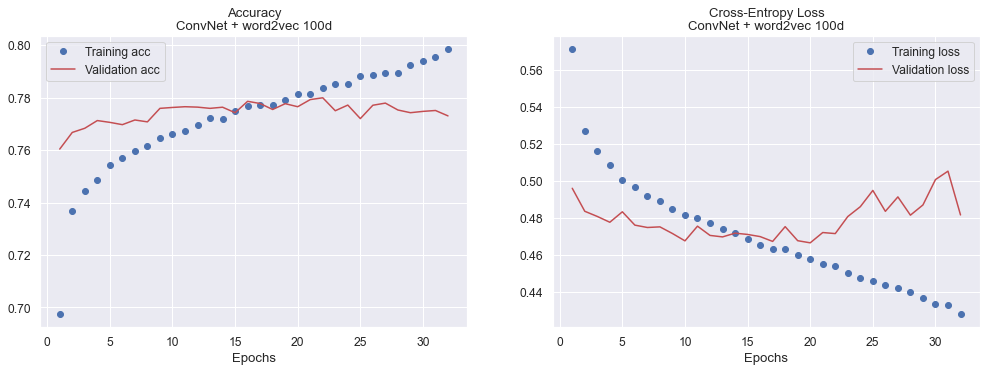

ConvNet, Word2Vec 100d: Generic tweets 
------------------------------------------------------------------------------------------
Validation acc: 0.77996874
test acc: 0.7766
ROC AUC: 0.7766000000000001
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.78     20000
         1.0       0.78      0.77      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



In [67]:
plot_train_history(convNet_w2v100d_history, subtitle='ConvNet + word2vec 100d')

# Evaluate model on test set
sequences = tokenizer_w2v100d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc = convNet_w2v100d.evaluate(x_tst,y_tst, verbose=0)
test_preds = convNet_w2v100d.predict_classes(x_tst)

print('ConvNet, Word2Vec 100d: Generic tweets \n'+'-'*90)
print('Validation acc:', convNet_w2v100d_history['val_acc'][np.argmax(convNet_w2v100d_history['val_acc'])])
print('test acc:', test_acc)
print('ROC AUC:', roc_auc_score(y_tst, test_preds))
print(classification_report(y_tst, test_preds))


Using the 100d word2vec embeddings and a convnet architecture,  we are able to achieve a test accuracy of 77.66%, just 0.1% below that of logistic regression.

#### GloVe 100d

In [68]:
### 1D ConvNet + GloVe 100d sequential

max_words = 40000  #Vocab size 

tokenizer_glv100d = Tokenizer(num_words=max_words)
tokenizer_glv100d.fit_on_texts(X_train.tolist())
sequences = tokenizer_glv100d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_glv100d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

# GloVe weights matrix for embedding layer
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, seq_idx in word_index.items():
    if seq_idx < max_words:
        embedding_vec = glove100_wv.get(word)
        if embedding_vec is not None:
            embedding_matrix[seq_idx] = embedding_vec

        
# Standardize embedding matrix
embed_mean = np.mean(embedding_matrix, axis=0)
embed_std = np.std(embedding_matrix, axis=0)
embedding_matrix = (embedding_matrix - embed_mean) / embed_std

embedding_matrix = embedding_matrix.astype('float32')

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


In [69]:
## Load / Train model 
lr = 0.001
es_patience = 10
epochs = 100
batch_sz = 128
model_path = os.path.join(pwd, 'models', 'convNet_glv100d.h5')
model_history_path = os.path.join(pwd, 'models', 'convNet_glv100d_history.pkl')

try:
    # Load existing model & training history
    convNet_glv100d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_glv100d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    convNet_glv100d = models.Sequential()
    convNet_glv100d.add(layers.Embedding(max_words, embedding_dim, input_length=data.shape[1]))
    convNet_glv100d.add(layers.Dropout(0.5)) 
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.MaxPool1D(2))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Conv1D(512, 2, activation='relu', padding='valid'))
    convNet_glv100d.add(layers.Flatten())
    convNet_glv100d.add(layers.Dense(512, activation='relu'))
    convNet_glv100d.add(layers.Dense(512, activation='relu'))
    convNet_glv100d.add(layers.Dropout(0.4))
    convNet_glv100d.add(layers.Dense(1, activation='sigmoid'))

    # SET weights for embedding layer - already trained GloVe
    convNet_glv100d.layers[0].set_weights([embedding_matrix])
    convNet_glv100d.layers[0].trainable = False

    print(convNet_glv100d.summary())
    
    convNet_glv100d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_glv100d_history = convNet_glv100d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_glv100d_history = convNet_glv100d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_glv100d_history, file)

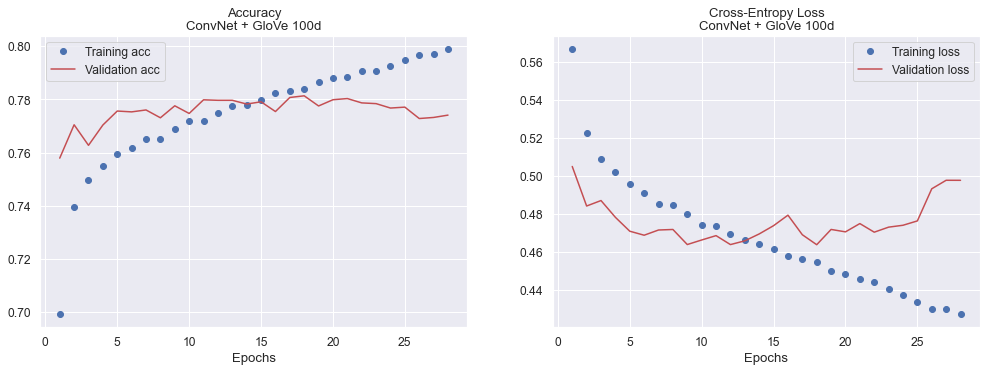

ConvNet, GloVe 100d: Generic tweets 
------------------------------------------------------------------------------------------
Validation acc: 0.7813125
test acc: 0.77985
ROC AUC: 0.77985
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77     20000
         1.0       0.76      0.81      0.79     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



In [70]:
plot_train_history(convNet_glv100d_history, subtitle='ConvNet + GloVe 100d')

# Evaluate model on test set
sequences = tokenizer_glv100d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc = convNet_glv100d.evaluate(x_tst,y_tst, verbose=0)
test_preds = convNet_glv100d.predict_classes(x_tst)

print('ConvNet, GloVe 100d: Generic tweets \n'+'-'*90)
print('Validation acc:', convNet_glv100d_history['val_acc'][np.argmax(convNet_glv100d_history['val_acc'])])
print('test acc:', test_acc)
print('ROC AUC:', roc_auc_score(y_tst, test_preds))
print(classification_report(y_tst, test_preds))


Now using the same CNN architecture as before, but GloVe 100d embeddings instead, we are finally able to outperform logistic regression, with a test accurach of 77.99%.

#### Task specific 100d
A task specific embedding involves training the weights of an input embedding layer alongside the rest of the CNN. This is easily done in Keras by specifying the embdding layer to allow its weights to be trainable.

In [71]:
### 1D ConvNet + 100d task-specific embedding w/ embedding layer
max_words = 40000  #Vocab size 

tokenizer_emb100d = Tokenizer(num_words=max_words)
tokenizer_emb100d.fit_on_texts(X_train.tolist())
sequences = tokenizer_emb100d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_emb100d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


In [72]:
## Load / Train model 
lr = 0.0001
es_patience = 5
epochs = 100
batch_sz = 128
model_path = os.path.join(pwd, 'models', 'convNet_emb100d.h5')
model_history_path = os.path.join(pwd, 'models','convNet_emb100d_history.pkl')

try:
    # Load existing model & training history
    convNet_emb100d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_emb100d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    convNet_emb100d = models.Sequential()
    convNet_emb100d.add(layers.Embedding(max_words, 100, input_length=data.shape[1]))
    convNet_emb100d.add(layers.Dropout(0.3)) 
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Conv1D(128, 2, activation='relu', padding='valid'))
    convNet_emb100d.add(layers.Dropout(0.3)) 
    convNet_emb100d.add(layers.Flatten())
    convNet_emb100d.add(layers.Dense(256, activation='relu'))
    convNet_emb100d.add(layers.Dense(256, activation='relu'))
    convNet_emb100d.add(layers.Dropout(0.4))
    convNet_emb100d.add(layers.Dense(1, activation='sigmoid'))

    print(convNet_emb100d.summary())
    
    convNet_emb100d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_emb100d_history = convNet_emb100d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_emb100d_history = convNet_emb100d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_emb100d_history, file)

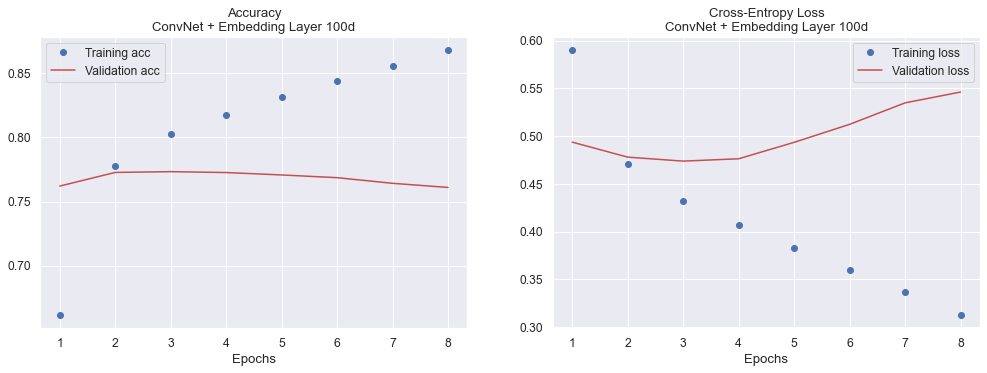

ConvNet, Embedding Layer 100d: Generic tweets 
------------------------------------------------------------------------------------------
Validation acc: 0.7733125
test acc: 0.771225
ROC AUC: 0.771225
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78     20000
         1.0       0.78      0.75      0.77     20000

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



In [73]:
plot_train_history(convNet_emb100d_history, subtitle='ConvNet + Embedding Layer 100d')

# Evaluate model on test set
sequences = tokenizer_emb100d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc = convNet_emb100d.evaluate(x_tst,y_tst, verbose=0)
test_preds = convNet_emb100d.predict_classes(x_tst)

print('ConvNet, Embedding Layer 100d: Generic tweets \n'+'-'*90)
print('Validation acc:', convNet_emb100d_history['val_acc'][np.argmax(convNet_emb100d_history['val_acc'])])
print('test acc:', test_acc)
print('ROC AUC:', roc_auc_score(y_tst, test_preds))
print(classification_report(y_tst, test_preds))


With a custom Keras embedding layer scheme, we are unable to outperform the linear regression model. This is probably due to there being too many weights to train in order to arrive at very good solution.

#### GloVe 200d
Since GloVe and ConvNets are the best pairing thus far, we will try to improve the network's predictive performance by increasing the dimensionality of the GloVe embeddings to 200. Additionally, the GloVe weights will not be frozen when initialized, which would allow small weight changes appropriate to our problem's dataset. 

With respect to the CNN architecture, it was changed from a sequential model to a parallel one. The three parallel split considers working with kernels of size 2, 3, and 4 separately, before combining their outputs. The different kernel sizes allow for different granularities of context to be examined in the text. The modified architecture also allows for less weights to be trained by the ConvNet while maintaining good performance. 

In [74]:
### 1D ConvNet + GloVe 200d 

max_words = 40000  #Vocab size 

tokenizer_glv200d = Tokenizer(num_words=max_words)
tokenizer_glv200d.fit_on_texts(X_train.tolist())
sequences = tokenizer_glv200d.texts_to_sequences(X_train.tolist())

word_index = tokenizer_glv200d.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences)
labels = y_train.to_numpy()
labels = labels / labels.max()  #Normalize from 0 to 1 since sigmoid activation at output
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Holdout Validation split
x_trn = data[:split_idx]
y_trn = labels[:split_idx]
x_val = data[split_idx:]
y_val = labels[split_idx:]

# GloVe weights matrix for embedding layer
embedding_dim = 200
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, seq_idx in word_index.items():
    if seq_idx < max_words:
        embedding_vec = glove200_wv.get(word)
        if embedding_vec is not None:
            embedding_matrix[seq_idx] = embedding_vec

        
# Standardize embedding matrix
embed_mean = np.mean(embedding_matrix, axis=0)
embed_std = np.std(embedding_matrix, axis=0)
embedding_matrix = (embedding_matrix - embed_mean) / embed_std

embedding_matrix = embedding_matrix.astype('float32')

130423 unique tokens
Data tensor shape:  (160000, 30)
Label tensor shape:  (160000,)


In [75]:
## Load / Train model 
lr = 0.0003
es_patience = 7
epochs = 100
batch_sz = 64
model_path = os.path.join(pwd, 'models', 'convNet_glv200d.h5')
model_history_path = os.path.join(pwd, 'models', 'convNet_glv200d_history.pkl')

try:
    # Load existing model & training history
    convNet_glv200d = models.load_model(model_path)    
    with open(model_history_path, 'rb') as f:
        convNet_glv200d_history = pickle.load(f)
    
except (FileNotFoundError, EOFError, ImportError, IOError):
    # Define model architecture
    input_seq = layers.Input(shape=(data.shape[1],), name='input')
    
    embeddings = layers.Embedding(max_words, embedding_dim, input_length=data.shape[1],
                                  weights=[embedding_matrix],
                                  trainable = True)(input_seq)
    
    dropout_emb = layers.Dropout(0.4)(embeddings)
    
    kern_two = layers.Conv1D(64, 2, activation='relu', padding='valid')(dropout_emb)
    kern_two = layers.Conv1D(64, 2, activation='relu', padding='valid')(kern_two)
    maxpool_two = layers.GlobalMaxPooling1D()(kern_two)
    
    kern_three = layers.Conv1D(64, 3, activation='relu', padding='valid')(dropout_emb)
    kern_three = layers.Conv1D(64, 3, activation='relu', padding='valid')(kern_three)
    maxpool_three = layers.GlobalMaxPooling1D()(kern_three)
    
    kern_four = layers.Conv1D(64, 4, activation='relu', padding='valid')(dropout_emb)
    kern_four = layers.Conv1D(64, 4, activation='relu', padding='valid')(kern_four)
    maxpool_four = layers.GlobalMaxPooling1D()(kern_four)
    
    merged = layers.concatenate([maxpool_two, maxpool_three, maxpool_four], axis=1)
    dropout1 = layers.Dropout(0.2)(merged)
    clf = layers.Dense(512, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.2)(clf)
    output = layers.Dense(1, activation='sigmoid')(dropout2)
    
    convNet_glv200d = models.Model(input_seq, output)

    
    print(convNet_glv200d.summary())
    
    convNet_glv200d.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['acc']
    )

    # Callbacks
    es = callbacks.EarlyStopping(
        monitor='val_acc',
        patience=es_patience, 
        verbose=1,
        restore_best_weights=True
    )

    mc = callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_acc',
        save_best_only=True
    )
    
    # Train model
    convNet_glv200d_history = convNet_glv200d.fit(
        x_trn,
        y_trn,
        epochs=epochs,
        batch_size=batch_sz,
        validation_data = (x_val, y_val),
        callbacks = [es, mc]
    )
    convNet_glv200d_history = convNet_glv200d_history.history
    
    # Save model training history
    with open(model_history_path, 'wb') as file:
        pickle.dump(convNet_glv200d_history, file)

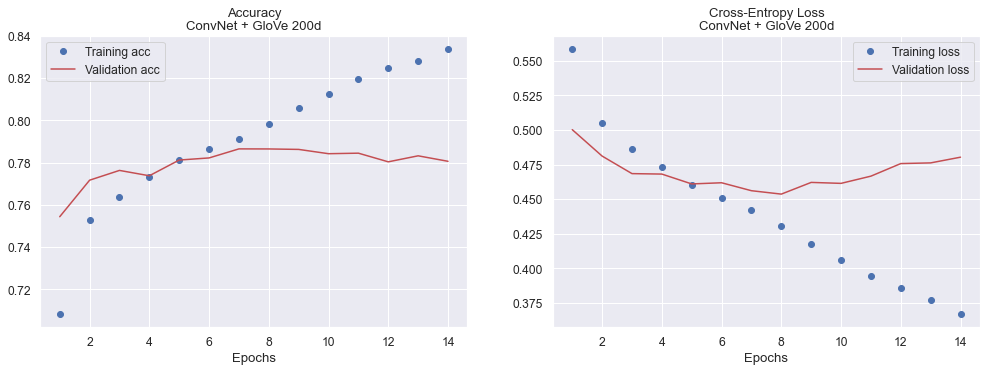

ConvNet, GloVe 200d: Generic tweets 
------------------------------------------------------------------------------------------
Validation acc: 0.78653127
test acc: 0.7847
ROC AUC: 0.7847
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     20000
         1.0       0.79      0.77      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000



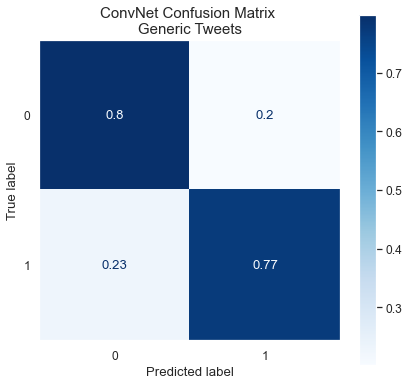

In [76]:
plot_train_history(convNet_glv200d_history, subtitle='ConvNet + GloVe 200d')

# Evaluate model on test set
sequences = tokenizer_glv200d.texts_to_sequences(X_test.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc_cnn_generic = convNet_glv200d.evaluate(x_tst,y_tst, verbose=0)
test_preds_prob_generic = convNet_glv200d.predict(x_tst)
test_preds = np.copy(test_preds_prob_generic)
test_preds[test_preds_prob_generic > 0.5] = 1
test_preds[test_preds_prob_generic <= 0.5] = 0
auc_cnn_generic = roc_auc_score(y_tst, test_preds)

print('ConvNet, GloVe 200d: Generic tweets \n'+'-'*90)
print('Validation acc:', convNet_glv200d_history['val_acc'][np.argmax(convNet_glv200d_history['val_acc'])])
print('test acc:', test_acc_cnn_generic)
print('ROC AUC:', auc_cnn_generic)
print(classification_report(y_tst, test_preds))

cnn_vm_vals = confusion_matrix(y_tst, test_preds)
cnn_vm_vals = cnn_vm_vals / np.sum(cnn_vm_vals, axis=1).reshape((-1,1))

cnn_cm = ConfusionMatrixDisplay(cnn_vm_vals, [0, 1])
fig, ax = plt.subplots(figsize=(6,6))
cnn_cm = cnn_cm.plot(cmap=plt.cm.Blues, ax=ax)

cnn_cm.ax_.set_title('ConvNet Confusion Matrix \nGeneric Tweets', fontsize=15)
plt.grid(False)
plt.show()

Using the new CNN architecture alongside the 200d GloVe word embeddings, we are able to achieve another increase in test accuracy for the generic tweet dataset, at 78.47%. This is quite impressive considering text sentiment classification is notoriously difficult and we are only training on a dataset of 160000 tweets. Like the other neural net architectures tested, the network overfitting was a major challenge with a text dataset this small. In this case, overfitting was mitigated by including multiple dropout layers and using early stopping during training.

Since the identification of negative tweets is the main concern, this model was able to achieve a 5% improvement in recall for a 1% drop in precision, improving the f1-score by 2% relative to the best found logistic regression model.

ConvNet, GloVe 200d: Airline tweets 
------------------------------------------------------------------------------------------
test acc: 0.78390086
ROC AUC: 0.8116544309576885
              precision    recall  f1-score   support

         0.0       0.95      0.76      0.85      9178
         1.0       0.48      0.86      0.62      2363

    accuracy                           0.78     11541
   macro avg       0.72      0.81      0.73     11541
weighted avg       0.86      0.78      0.80     11541



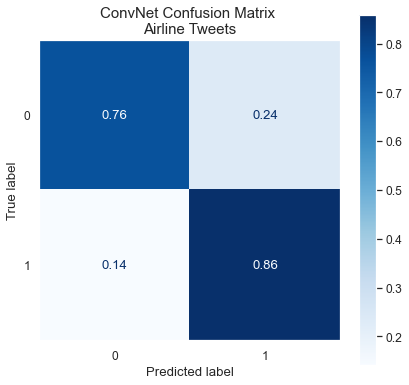

In [77]:
### ConvNet Performance statistics on airline test-set
sequences = tokenizer_glv200d.texts_to_sequences(X_test_airline.tolist())
x_tst = pad_sequences(sequences, maxlen=data.shape[1])
y_tst = y_test_airline.to_numpy()
y_tst = y_tst / y_tst.max() 
test_loss, test_acc_cnn_airline = convNet_glv200d.evaluate(x_tst,y_tst, verbose=0)
test_preds_prob_airline = convNet_glv200d.predict(x_tst)
test_preds = np.copy(test_preds_prob_airline)
test_preds[test_preds_prob_airline > 0.5] = 1
test_preds[test_preds_prob_airline <= 0.5] = 0
auc_cnn_airline = roc_auc_score(y_tst, test_preds)

print('ConvNet, GloVe 200d: Airline tweets \n'+'-'*90)
print('test acc:', test_acc_cnn_airline)
print('ROC AUC:', auc_cnn_airline)
print(classification_report(y_tst, test_preds))


cnn_vm_vals = confusion_matrix(y_tst, test_preds)
cnn_vm_vals = cnn_vm_vals / np.sum(cnn_vm_vals, axis=1).reshape((-1,1)) #Normalize for imbalanced data

cnn_cm = ConfusionMatrixDisplay(cnn_vm_vals, [0, 1])
fig, ax = plt.subplots(figsize=(6,6))
cnn_cm = cnn_cm.plot(cmap=plt.cm.Blues, ax=ax)

cnn_cm.ax_.set_title('ConvNet Confusion Matrix \nAirline Tweets', fontsize=15)
plt.grid(False)
plt.show()

A similar trend is observed on the imbalanced airline tweet test set, where we observe a 3% increase in recall for a 1% drop in precision for negative tweets, relative to the best found linear regression model. The CNN model also maintains its high accuracy score of 78.39% which is further confirms the model is not overfitting and is the best performing classifier.

## Best Classifier Summary
To summarize our findings, we can compare the ROC curves and accuracy scores of our best performing ConvNet against our best found linear classifier.

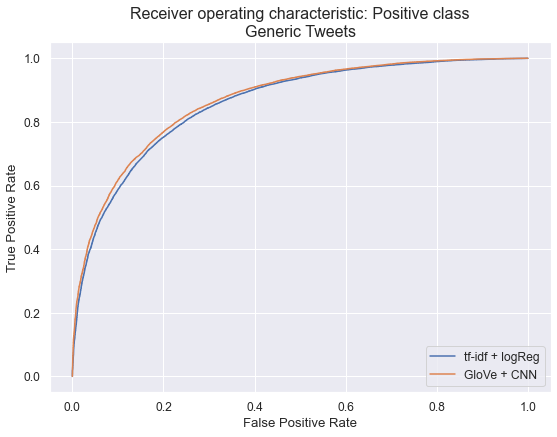

,ROC AUC (%),Test Accuracy (%)
tf-idf + logReg,77.75,77.75
GloVe + CNN,78.47,78.47


In [78]:
# Generic dataset summary stats
plt.figure(figsize=(8,6))
lr_test_preds_prob_generic = lr_final.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_test_preds_prob_generic, pos_label=4)
plt.plot(fpr_lr, tpr_lr, label='tf-idf + logReg')
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, test_preds_prob_generic, pos_label=4)
plt.plot(fpr_cnn, tpr_cnn, label='GloVe + CNN')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Positive class\nGeneric Tweets', fontsize=16)
plt.show()

generic_summary = {'ROC AUC (%)':[auc_lr_generic, auc_cnn_generic],
                   'Test Accuracy (%)':[lr_testacc_generic, test_acc_cnn_generic]}

generic_summary = pd.DataFrame(generic_summary, index=['tf-idf + logReg', 'GloVe + CNN']).round(4) *100
generic_summary.head()

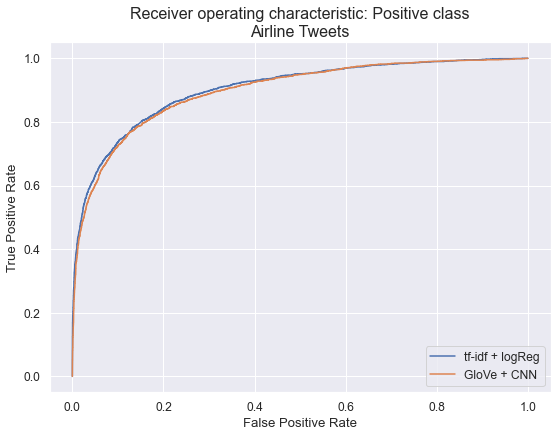

,ROC AUC (%),Test Accuracy (%)
tf-idf + logReg,80.76,76.07
GloVe + CNN,81.17,78.39


In [79]:
# Airline dataset summary stats
plt.figure(figsize=(8,6))
lr_test_preds_prob_airline = lr_final.predict_proba(X_test_airline)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_airline, lr_test_preds_prob_airline, pos_label=4)
plt.plot(fpr_lr, tpr_lr, label='tf-idf + logReg')

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test_airline, test_preds_prob_airline, pos_label=4)
plt.plot(fpr_cnn, tpr_cnn, label='GloVe + CNN')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Positive class\nAirline Tweets', fontsize=16)
plt.show()

airline_summary = {'ROC AUC (%)':[auc_lr_airline, auc_cnn_airline],
                   'Test Accuracy (%)':[lr_testacc_airline, test_acc_cnn_airline]}

airline_summary = pd.DataFrame(airline_summary, index=['tf-idf + logReg', 'GloVe + CNN']).round(4) *100
airline_summary.head()

Based on the ROC plots and the test accuracies, the CNN model implementing 200d GloVe vectors clearly outperforms the logistic regression model on both generic and airline tweets based on higher test accuracy and area under ROC.

## Conclusions
Public opinion on Twitter tells us that most of the feedback regarding US airlines in 2015 had negative connotation. This indicates that customers were generally dissatisfied with US airline service that year. In 2015, the three most tweeted airlines were United, US Airways, and American Air, in descending order. A quick web search shows that United received a lot of attention from the public due to mishandled customer service incidents in 2015. Judging from the complaints of US airline customers, customer service issues were the most frequent, followed by late or cancelled flights. This information could act as an indicator for what a US airline company should focus on improving.

The best predictive model for tweet sentiment classification was a **convolutional neural net (CNN) leveraging pretrained 200 dimensional GloVe word embeddings**. This model was able to achieve a **test accuracy of ~78.5%**, with an **ROC AUC of 0.81** on the set of airline tweets. The accuracy of the CNN model could be further improved by training on a larger set of data. This would help to prevent overfitting, while allowing the model to generalize better to unseen data.